In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom
import io
import imageio
from tensorflow.keras.preprocessing import image_dataset_from_directory
import seaborn as sns

from sklearn.model_selection import train_test_split


import PIL
from PIL import ImageFont, ImageDraw, Image

from ydata_profiling import ProfileReport

C:\Users\ilyau\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# %pip install tensorflow-gpu==2.8.3

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
dir_train = 'A://workspace//datasets//tiny_imagenet//train.parquet'
dir_valid = 'A://workspace//datasets//tiny_imagenet//valid.parquet'

In [5]:
train_dataset = pd.read_parquet(dir_train, engine='pyarrow')
train_dataset.head()

,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0


In [6]:
valid_dataset = pd.read_parquet(dir_valid, engine='pyarrow')
valid_dataset.head()

,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0


In [7]:
%%time
train_dataset['image_matrix'] = train_dataset['image'].apply(lambda x: np.array(Image.open(io.BytesIO(x['bytes']))))
train_dataset.head()

CPU times: total: 14 s
Wall time: 14.2 s


,image,label,image_matrix
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0,"[[[255, 136, 193], [255, 138, 192], [249, 146,..."
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0,"[[[20, 33, 7], [19, 32, 6], [23, 31, 10], [28,..."
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0,"[[[120, 124, 127], [89, 93, 96], [80, 84, 87],..."
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0,"[[[144, 170, 245], [121, 147, 221], [140, 166,..."
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0,"[[[144, 145, 147], [141, 142, 144], [140, 140,..."


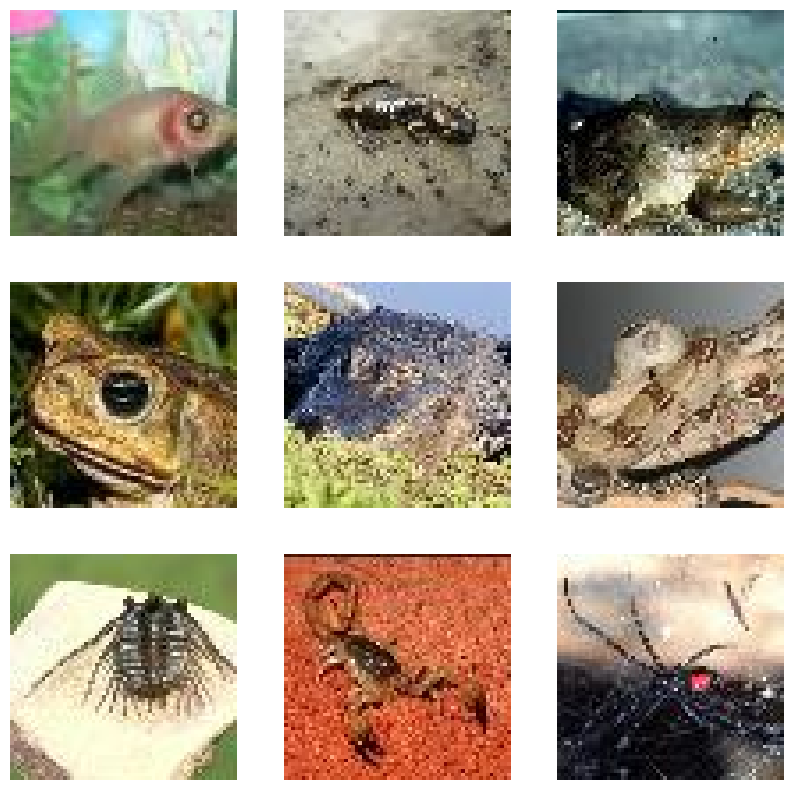

In [8]:
plt.figure(figsize=(10, 10))
for i, image in train_dataset['image_matrix'][:4500:500].items():
    ax = plt.subplot(3, 3, i//500 + 1)
    plt.imshow(image)
    plt.axis("off")

In [9]:
len(train_dataset['image_matrix'].iloc[1])

64

In [10]:
# check count and amount of classes
labels_count = list(train_dataset['label'].value_counts())
len(labels_count), set(labels_count)

(200, {500})

Split train into train and test

In [11]:
# train_dataset with stratify
img_train_orig, img_test_orig, label_train, label_test = train_test_split(train_dataset['image_matrix'], train_dataset['label'], test_size=0.2, random_state=42,
                                                               stratify=train_dataset['label'])

In [12]:
img_train_orig.shape, label_train.shape, img_test_orig.shape, label_test.shape

((80000,), (80000,), (20000,), (20000,))

In [13]:
def data_augmenter():
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip("horizontal"))
    data_augmentation.add(RandomFlip("vertical"))
    data_augmentation.add(RandomRotation(0.2))
    data_augmentation.add(RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)))
    
    return data_augmentation

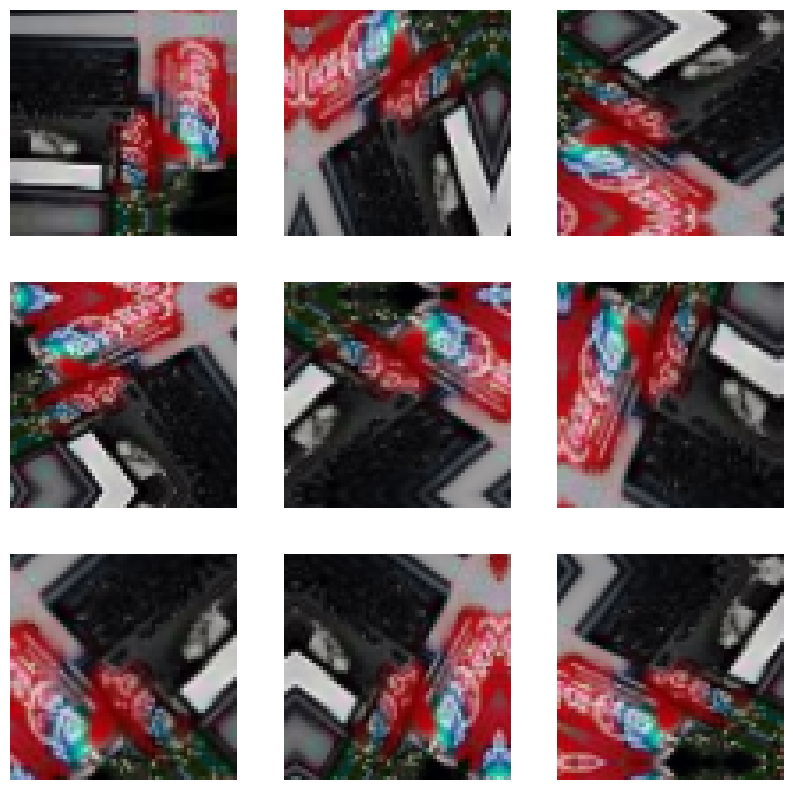

In [14]:
data_augmentation = data_augmenter()

plt.figure(figsize=(10, 10))
first_image = img_train_orig.iloc[3]
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

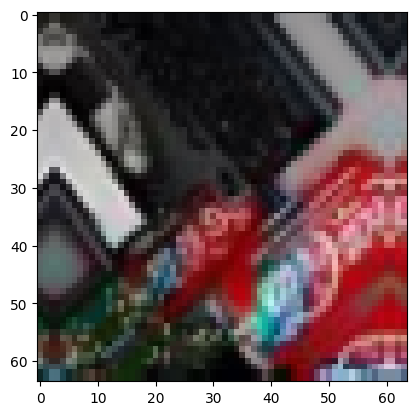

In [15]:
plt.imshow(data_augmentation(tf.expand_dims(first_image, 0))[0]/255)

In [16]:
# def convert_to_one_hot(Y, C):
#     Y = np.eye(C)[Y.reshape(-1)].T
#     return Y

In [17]:
img_train = img_train_orig/255
img_test = img_test_orig/255

In [18]:
img_train = (np.repeat(im[:, :, np.newaxis], 3, axis=2) if im.shape == (64,64) else im for im in img_train)
img_test = (np.repeat(im[:, :, np.newaxis], 3, axis=2) if im.shape == (64,64) else im for im in img_test)

In [19]:
img_train = np.stack(list(img_train))
img_test = np.stack(list(img_test))

In [20]:
img_train.shape

(80000, 64, 64, 3)

In [21]:
label_train = pd.get_dummies(label_train, dtype='float32')
label_test= pd.get_dummies(label_test, dtype='float32')

In [22]:
with tf.device('/cpu:0'):
    label_train = tf.convert_to_tensor(label_train.values, np.float32)
    label_test = tf.convert_to_tensor(label_test.values, np.float32)
    img_train = tf.convert_to_tensor(img_train, np.float32)
    img_test = tf.convert_to_tensor(img_test, np.float32)

In [23]:
train_dataset = tf.data.Dataset.from_tensor_slices((img_train, label_train)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((img_test, label_test)).batch(64)

In [63]:
# def convolutional_model(input_shape, drop_out=0.3):
#     input_img = tf.keras.Input(shape=input_shape)
#     X = data_augmentation(input_img) # это с каждой эпохой происходит ци как? это вообще здесь должно быть?

#     X = tf.keras.layers.Conv2D(filters = 16 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
#     X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(1, 1), padding='same')(X)

#     X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
#     X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(1, 1), padding='same')(X)

#     X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
#     X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(1, 1), padding='same')(X)

   
#     X = tf.keras.layers.Flatten()(X)

#     # X = tf.keras.layers.Dense(units=512, activation='relu')(X)
#     X = tf.keras.layers.Dense(units=200, activation='softmax')(X)
    
#     model = tf.keras.Model(inputs=input_img, outputs=X)
#     return model

# conv_model = convolutional_model((64, 64, 3))
# print(conv_model.summary())

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_62 (Conv2D)          (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_63 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                     

In [25]:
# def convolutional_model(input_shape, drop_out=0.3):
#     input_img = tf.keras.Input(shape=input_shape)
#     X = data_augmentation(input_img) # это с каждой эпохой происходит ци как? это вообще здесь должно быть?

#     X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
#     X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)

#     X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
#     X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)

#     X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
#     X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)

   
#     X = tf.keras.layers.Flatten()(X)

#     # X = tf.keras.layers.Dense(units=512, activation='relu')(X)
#     X = tf.keras.layers.Dense(units=200, activation='softmax')(X)
    
#     model = tf.keras.Model(inputs=input_img, outputs=X)
#     return model

# conv_model = convolutional_model((64, 64, 3))
# conv_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                       

In [26]:


# conv_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])

# history = conv_model.fit(train_dataset, validation_data=test_dataset,epochs=100,workers=-1, callbacks=[tf.keras.callbacks.EarlyStopping(
#         monitor='val_loss',
#         min_delta=0.01,
#         patience=10,
#         verbose=0,
#         mode='auto',
#         baseline=None,
#         restore_best_weights=False
#     )])

Epoch 1/100
1250/1250 [==============================] - 17s 11ms/step - loss: 4.8675 - accuracy: 0.0477 - val_loss: 4.7219 - val_accuracy: 0.0768
Epoch 2/100
1250/1250 [==============================] - 13s 10ms/step - loss: 4.4346 - accuracy: 0.1015 - val_loss: 4.5772 - val_accuracy: 0.1028
Epoch 3/100
1250/1250 [==============================] - 13s 10ms/step - loss: 4.2624 - accuracy: 0.1234 - val_loss: 4.5490 - val_accuracy: 0.1172
Epoch 4/100
1250/1250 [==============================] - 13s 10ms/step - loss: 4.1565 - accuracy: 0.1393 - val_loss: 4.4902 - val_accuracy: 0.1279
Epoch 5/100
1250/1250 [==============================] - 13s 10ms/step - loss: 4.0719 - accuracy: 0.1508 - val_loss: 4.4693 - val_accuracy: 0.1311
Epoch 6/100
1250/1250 [==============================] - 13s 10ms/step - loss: 3.9959 - accuracy: 0.1621 - val_loss: 4.4179 - val_accuracy: 0.1381
Epoch 7/100
1250/1250 [==============================] - 13s 10ms/step - loss: 3.9286 - accuracy: 0.1718 - val_loss: 4

In [27]:
# def convolutional_model(input_shape, drop_out=0.3):
#     input_img = tf.keras.Input(shape=input_shape)
#     X = data_augmentation(input_img) # это с каждой эпохой происходит ци как? это вообще здесь должно быть?

#     X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
#     X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)

#     X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
#     X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)

#     X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
#     X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)

   
#     X = tf.keras.layers.Flatten()(X)

#     X = tf.keras.layers.Dense(units=512, activation='relu')(X)
#     X = tf.keras.layers.Dense(units=200, activation='softmax')(X)
    
#     model = tf.keras.Model(inputs=input_img, outputs=X)
#     return model

# conv_model = convolutional_model((64, 64, 3))
# conv_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                      

In [28]:
conv_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history = conv_model.fit(train_dataset, validation_data=test_dataset, batch_size=16, epochs=100,workers=-1, callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.01,
        patience=10,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=False
    )])

Epoch 1/100
1250/1250 [==============================] - 14s 11ms/step - loss: 4.9278 - accuracy: 0.0383 - val_loss: 4.7290 - val_accuracy: 0.0657
Epoch 2/100
1250/1250 [==============================] - 14s 11ms/step - loss: 4.4928 - accuracy: 0.0883 - val_loss: 4.5236 - val_accuracy: 0.0970
Epoch 3/100
1250/1250 [==============================] - 14s 11ms/step - loss: 4.2968 - accuracy: 0.1119 - val_loss: 4.4762 - val_accuracy: 0.1067
Epoch 4/100
1250/1250 [==============================] - 14s 11ms/step - loss: 4.1635 - accuracy: 0.1302 - val_loss: 4.4653 - val_accuracy: 0.1160
Epoch 5/100
1250/1250 [==============================] - 14s 11ms/step - loss: 4.0678 - accuracy: 0.1423 - val_loss: 4.4440 - val_accuracy: 0.1211
Epoch 6/100
1250/1250 [==============================] - 14s 11ms/step - loss: 3.9899 - accuracy: 0.1544 - val_loss: 4.4124 - val_accuracy: 0.1276
Epoch 7/100
1250/1250 [==============================] - 14s 11ms/step - loss: 3.9205 - accuracy: 0.1647 - val_loss: 4

In [31]:
# # stride = 2 valid
# def convolutional_model(input_shape, drop_out=0.3):
#     input_img = tf.keras.Input(shape=input_shape)
#     X = data_augmentation(input_img) # это с каждой эпохой происходит ци как? это вообще здесь должно быть?

#     X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
#     X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)

#     X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
#     X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)

#     X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
#     X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)

#     X = tf.keras.layers.Flatten()(X)

#     X = tf.keras.layers.Dense(units=200, activation='softmax')(X)
    
#     model = tf.keras.Model(inputs=input_img, outputs=X)
#     return model

# conv_model = convolutional_model((64, 64, 3))
# print(conv_model.summary())

# conv_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])

# history = conv_model.fit(train_dataset, validation_data=test_dataset, batch_size=16, epochs=100,workers=-1, callbacks=[tf.keras.callbacks.EarlyStopping(
#         monitor='val_loss',
#         min_delta=0.01,
#         patience=10,
#         verbose=0,
#         mode='auto',
#         baseline=None,
#         restore_best_weights=False
#     )])

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_19 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                      

In [32]:
# # stride = 2 same
# def convolutional_model(input_shape, drop_out=0.3):
#     input_img = tf.keras.Input(shape=input_shape)
#     X = data_augmentation(input_img) # это с каждой эпохой происходит ци как? это вообще здесь должно быть?

#     X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
#     X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='same')(X)

#     X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
#     X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='same')(X)

#     X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
#     X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='same')(X)

   
#     X = tf.keras.layers.Flatten()(X)

#     X = tf.keras.layers.Dense(units=200, activation='softmax')(X)
    
#     model = tf.keras.Model(inputs=input_img, outputs=X)
#     return model

# conv_model = convolutional_model((64, 64, 3))
# print(conv_model.summary())

# conv_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])

# history = conv_model.fit(train_dataset, validation_data=test_dataset, batch_size=16, epochs=100,workers=-1, callbacks=[tf.keras.callbacks.EarlyStopping(
#         monitor='val_loss',
#         min_delta=0.01,
#         patience=10,
#         verbose=0,
#         mode='auto',
#         baseline=None,
#         restore_best_weights=False
#     )])

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_22 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                      

In [33]:
# def convolutional_model(input_shape, drop_out=0.3):
#     input_img = tf.keras.Input(shape=input_shape)
#     X = data_augmentation(input_img) # это с каждой эпохой происходит ци как? это вообще здесь должно быть?

#     X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
#     X = tf.keras.layers.ReLU()(X)
#     X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)

#     X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
#     X = tf.keras.layers.ReLU()(X)
#     X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)

#     X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
#     X = tf.keras.layers.ReLU()(X)
#     X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)

#     X = tf.keras.layers.Flatten()(X)

#     X = tf.keras.layers.Dense(units=200, activation='softmax')(X)
    
#     model = tf.keras.Model(inputs=input_img, outputs=X)
#     return model

# conv_model = convolutional_model((64, 64, 3))
# print(conv_model.summary())

# conv_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])

# history = conv_model.fit(train_dataset, validation_data=test_dataset, batch_size=16, epochs=100,workers=-1, callbacks=[tf.keras.callbacks.EarlyStopping(
#         monitor='val_loss',
#         min_delta=0.01,
#         patience=10,
#         verbose=0,
#         mode='auto',
#         baseline=None,
#         restore_best_weights=False
#     )])

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_25 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 re_lu (ReLU)                (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 32, 32, 64)        18496     
                                                           

In [34]:
# def convolutional_model(input_shape, drop_out=0.3):
#     input_img = tf.keras.Input(shape=input_shape)
#     X = data_augmentation(input_img) # это с каждой эпохой происходит ци как? это вообще здесь должно быть?

#     X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
#     X = tf.keras.layers.ReLU()(X)
#     X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
#     X = tf.keras.layers.Dropout(drop_out)(X)

#     X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
#     X = tf.keras.layers.ReLU()(X)
#     X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
#     X = tf.keras.layers.Dropout(drop_out)(X)

#     X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
#     X = tf.keras.layers.ReLU()(X)
#     X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
#     X = tf.keras.layers.Dropout(drop_out)(X)

#     X = tf.keras.layers.Flatten()(X)
    
#     X = tf.keras.layers.Dense(units=200, activation='softmax')(X)
    
#     model = tf.keras.Model(inputs=input_img, outputs=X)
#     return model

# conv_model = convolutional_model((64, 64, 3))
# print(conv_model.summary())

# conv_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])

# history = conv_model.fit(train_dataset, validation_data=test_dataset, batch_size=16, epochs=100,workers=-1, callbacks=[tf.keras.callbacks.EarlyStopping(
#         monitor='val_loss',
#         min_delta=0.01,
#         patience=10,
#         verbose=0,
#         mode='auto',
#         baseline=None,
#         restore_best_weights=False
#     )])

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_28 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 re_lu_3 (ReLU)              (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 32, 32, 32)        0         
                                                           

In [35]:
# def convolutional_model(input_shape, drop_out=0.3):
#     input_img = tf.keras.Input(shape=input_shape)
#     X = data_augmentation(input_img) # это с каждой эпохой происходит ци как? это вообще здесь должно быть?

#     X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
#     X = tf.keras.layers.ReLU()(X)
#     X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
#     X = tf.keras.layers.Dropout(drop_out)(X)

#     X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
#     X = tf.keras.layers.ReLU()(X)
#     X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
#     X = tf.keras.layers.Dropout(drop_out)(X)

#     X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
#     X = tf.keras.layers.ReLU()(X)
#     X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
#     X = tf.keras.layers.Dropout(drop_out)(X)

#     X = tf.keras.layers.Flatten()(X)

#     X = tf.keras.layers.Dense(units=512, activation='relu')(X)
#     X = tf.keras.layers.Dense(units=200, activation='softmax')(X)
    
#     model = tf.keras.Model(inputs=input_img, outputs=X)
#     return model

# conv_model = convolutional_model((64, 64, 3))
# print(conv_model.summary())

# conv_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])

# history = conv_model.fit(train_dataset, validation_data=test_dataset, batch_size=16, epochs=100,workers=-1, callbacks=[tf.keras.callbacks.EarlyStopping(
#         monitor='val_loss',
#         min_delta=0.01,
#         patience=10,
#         verbose=0,
#         mode='auto',
#         baseline=None,
#         restore_best_weights=False
#     )])

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_31 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 re_lu_6 (ReLU)              (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 32, 32, 32)        0         
                                                           

# NEXT

In [29]:
# 40 20
def convolutional_model(input_shape, drop_out=0.3):
    input_img = tf.keras.Input(shape=input_shape)
    X = data_augmentation(input_img) # это с каждой эпохой происходит ци как? это вообще здесь должно быть?

    X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.BatchNormalization(axis=3)(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.BatchNormalization(axis=3)(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.BatchNormalization(axis=3)(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Flatten()(X)
    X = tf.keras.layers.Dense(units=2048, activation='relu')(X)
    X = tf.keras.layers.Dense(units=1024, activation='relu')(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tf.keras.layers.Dropout(0.5)(X)
    X = tf.keras.layers.Dense(units=512, activation='relu')(X)

    X = tf.keras.layers.Dense(units=200, activation='softmax')(X)
    
    model = tf.keras.Model(inputs=input_img, outputs=X)
    return model

conv_model = convolutional_model((64, 64, 3))
print(conv_model.summary())

conv_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history = conv_model.fit(train_dataset, validation_data=test_dataset, batch_size=16, epochs=100,workers=-1, callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.01,
        patience=10,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=False
    )])

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_15 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 batch_normalization_20 (Bat  (None, 64, 64, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 32, 32, 32)        0   

In [30]:

def convolutional_model(input_shape, drop_out=0.3):
    input_img = tf.keras.Input(shape=input_shape)
    X = data_augmentation(input_img) # это с каждой эпохой происходит ци как? это вообще здесь должно быть?

    X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Flatten()(X)

    X = tf.keras.layers.Dense(units=256, activation='relu')(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tf.keras.layers.Dropout(0.5)(X)
    # X = tf.keras.layers.Dense(units=512, activation='relu')(X)

    X = tf.keras.layers.Dense(units=200, activation='softmax')(X)
    
    model = tf.keras.Model(inputs=input_img, outputs=X)
    return model

conv_model = convolutional_model((64, 64, 3))
print(conv_model.summary())

conv_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history = conv_model.fit(train_dataset, validation_data=test_dataset, batch_size=1024, epochs=100,workers=-1, callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.01,
        patience=10,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=False
    )])

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_18 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 batch_normalization_24 (Bat  (None, 64, 64, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 dropout_22 (Dropout)        (None, 32, 32, 32)        0   

In [31]:

def convolutional_model(input_shape, drop_out=0.3):
    input_img = tf.keras.Input(shape=input_shape)
    X = data_augmentation(input_img) # это с каждой эпохой происходит ци как? это вообще здесь должно быть?

    X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Flatten()(X)
    
    X = tf.keras.layers.Dense(units=512, activation='relu')(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tf.keras.layers.Dropout(0.5)(X)
    # X = tf.keras.layers.Dense(units=512, activation='relu')(X)

    X = tf.keras.layers.Dense(units=200, activation='softmax')(X)
    
    model = tf.keras.Model(inputs=input_img, outputs=X)
    return model

conv_model = convolutional_model((64, 64, 3))
print(conv_model.summary())

conv_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history = conv_model.fit(train_dataset, validation_data=test_dataset, batch_size=1024, epochs=100,workers=-1, callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.01,
        patience=10,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=False
    )])

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_21 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 batch_normalization_28 (Bat  (None, 64, 64, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 dropout_26 (Dropout)        (None, 32, 32, 32)        0   

In [32]:

def convolutional_model(input_shape, drop_out=0.3):
    input_img = tf.keras.Input(shape=input_shape)
    X = data_augmentation(input_img) # это с каждой эпохой происходит ци как? это вообще здесь должно быть?

    X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Flatten()(X)

    X = tf.keras.layers.Dense(units=1024, activation='relu')(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tf.keras.layers.Dropout(0.5)(X)
    X = tf.keras.layers.Dense(units=512, activation='relu')(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tf.keras.layers.Dropout(0.5)(X)
    # X = tf.keras.layers.Dense(units=512, activation='relu')(X)

    X = tf.keras.layers.Dense(units=200, activation='softmax')(X)
    
    model = tf.keras.Model(inputs=input_img, outputs=X)
    return model

conv_model = convolutional_model((64, 64, 3))
print(conv_model.summary())

conv_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history = conv_model.fit(train_dataset, validation_data=test_dataset, batch_size=1024, epochs=100,workers=-1, callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.01,
        patience=10,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=False
    )])

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_25 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 batch_normalization_33 (Bat  (None, 64, 64, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 dropout_31 (Dropout)        (None, 32, 32, 32)        0   

In [33]:

def convolutional_model(input_shape, drop_out=0.3):
    input_img = tf.keras.Input(shape=input_shape)
    X = data_augmentation(input_img) # это с каждой эпохой происходит ци как? это вообще здесь должно быть?

    X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    # X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    # X = tfl.BatchNormalization()(X)
    # X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    # X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Flatten()(X)

    # X = tf.keras.layers.Dense(units=1024, activation='relu')(X)
    # X = tfl.BatchNormalization(axis = 1)(X)
    # X = tf.keras.layers.Dropout(0.5)(X)
    # X = tf.keras.layers.Dense(units=512, activation='relu')(X)
    # X = tfl.BatchNormalization(axis = 1)(X)
    # X = tf.keras.layers.Dropout(0.5)(X)
    # X = tf.keras.layers.Dense(units=512, activation='relu')(X)

    X = tf.keras.layers.Dense(units=200, activation='softmax')(X)
    
    model = tf.keras.Model(inputs=input_img, outputs=X)
    return model

conv_model = convolutional_model((64, 64, 3))
print(conv_model.summary())

conv_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history = conv_model.fit(train_dataset, validation_data=test_dataset, batch_size=1024, epochs=100,workers=-1, callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.01,
        patience=10,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=False
    )])

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_29 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 conv2d_30 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 conv2d_31 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 batch_normalization_39 (Bat  (None, 64, 64, 32)       128       
 chNormalization)                                                
                                                           

# NOT BAD

In [34]:

def convolutional_model(input_shape, drop_out=0.3):
    input_img = tf.keras.Input(shape=input_shape)
    X = data_augmentation(input_img) # это с каждой эпохой происходит ци как? это вообще здесь должно быть?

    X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Flatten()(X)

    # X = tf.keras.layers.Dense(units=1024, activation='relu')(X)
    # X = tfl.BatchNormalization(axis = 1)(X)
    # X = tf.keras.layers.Dropout(0.5)(X)
    X = tf.keras.layers.Dense(units=512, activation='relu')(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tf.keras.layers.Dropout(0.5)(X)
    # X = tf.keras.layers.Dense(units=512, activation='relu')(X)

    X = tf.keras.layers.Dense(units=200, activation='softmax')(X)
    
    model = tf.keras.Model(inputs=input_img, outputs=X)
    return model

conv_model = convolutional_model((64, 64, 3))
print(conv_model.summary())

conv_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history = conv_model.fit(train_dataset, validation_data=test_dataset, batch_size=1024, epochs=100,workers=-1, callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.01,
        patience=10,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=False
    )])

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_38 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 conv2d_39 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 conv2d_40 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 batch_normalization_42 (Bat  (None, 64, 64, 32)       128       
 chNormalization)                                                
                                                           

In [35]:

def convolutional_model(input_shape, drop_out=0.3):
    input_img = tf.keras.Input(shape=input_shape)
    X = data_augmentation(input_img) # это с каждой эпохой происходит ци как? это вообще здесь должно быть?

    X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Flatten()(X)

    X = tf.keras.layers.Dense(units=1024, activation='relu')(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tf.keras.layers.Dropout(0.5)(X)
    X = tf.keras.layers.Dense(units=512, activation='relu')(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tf.keras.layers.Dropout(0.5)(X)
    # X = tf.keras.layers.Dense(units=512, activation='relu')(X)

    X = tf.keras.layers.Dense(units=200, activation='softmax')(X)
    
    model = tf.keras.Model(inputs=input_img, outputs=X)
    return model

conv_model = convolutional_model((64, 64, 3))
print(conv_model.summary())

conv_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history = conv_model.fit(train_dataset, validation_data=test_dataset, batch_size=1024, epochs=100,workers=-1, callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.01,
        patience=10,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=False
    )])

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_50 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 conv2d_51 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 conv2d_52 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 batch_normalization_47 (Bat  (None, 64, 64, 32)       128       
 chNormalization)                                                
                                                           

# START

In [23]:
def convolutional_model(input_shape, drop_out=0.3):
    input_img = tf.keras.Input(shape=input_shape)
    X = data_augmentation(input_img) # это с каждой эпохой происходит ци как? это вообще здесь должно быть?

    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 512 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 512 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 512 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 1024 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 1024 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 1024 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Flatten()(X)

    X = tf.keras.layers.Dense(units=1024, activation='relu')(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tf.keras.layers.Dropout(0.5)(X)
    X = tf.keras.layers.Dense(units=512, activation='relu')(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tf.keras.layers.Dropout(0.5)(X)
    # X = tf.keras.layers.Dense(units=512, activation='relu')(X)

    X = tf.keras.layers.Dense(units=200, activation='softmax')(X)
    
    model = tf.keras.Model(inputs=input_img, outputs=X)
    return model

conv_model = convolutional_model((64, 64, 3))
print(conv_model.summary())

conv_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history = conv_model.fit(train_dataset, validation_data=test_dataset, batch_size=64, epochs=100,workers=-1, callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.01,
        patience=10,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=False
    )])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 128)       3584      
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 128)      512       
 ormalization)                                                   
                                                             

In [24]:
def convolutional_model(input_shape, drop_out=0.3):
    input_img = tf.keras.Input(shape=input_shape)
    X = data_augmentation(input_img) # это с каждой эпохой происходит ци как? это вообще здесь должно быть?

    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 512 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 512 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 512 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 1024 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 1024 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 1024 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Flatten()(X)

    # X = tf.keras.layers.Dense(units=1024, activation='relu')(X)
    # X = tfl.BatchNormalization(axis = 1)(X)
    # X = tf.keras.layers.Dropout(0.5)(X)
    X = tf.keras.layers.Dense(units=512, activation='relu')(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tf.keras.layers.Dropout(0.5)(X)
    # X = tf.keras.layers.Dense(units=512, activation='relu')(X)

    X = tf.keras.layers.Dense(units=200, activation='softmax')(X)
    
    model = tf.keras.Model(inputs=input_img, outputs=X)
    return model

conv_model = convolutional_model((64, 64, 3))
print(conv_model.summary())

conv_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history = conv_model.fit(train_dataset, validation_data=test_dataset, batch_size=64, epochs=100,workers=-1, callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.01,
        patience=10,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=False
    )])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (None, 64, 64, 128)       3584      
                                                                 
 conv2d_13 (Conv2D)          (None, 64, 64, 128)       147584    
                                                                 
 conv2d_14 (Conv2D)          (None, 64, 64, 128)       147584    
                                                                 
 batch_normalization_6 (Batc  (None, 64, 64, 128)      512       
 hNormalization)                                                 
                                                           

In [25]:
def convolutional_model(input_shape, drop_out=0.3):
    input_img = tf.keras.Input(shape=input_shape)
    X = data_augmentation(input_img)

    X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 512 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 512 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 512 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 1024 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 1024 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 1024 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Flatten()(X)


    X = tf.keras.layers.Dense(units=256, activation='relu')(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tf.keras.layers.Dropout(0.5)(X)

    X = tf.keras.layers.Dense(units=200, activation='softmax')(X)
    
    model = tf.keras.Model(inputs=input_img, outputs=X)
    return model

conv_model = convolutional_model((64, 64, 3))
print(conv_model.summary())

conv_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history = conv_model.fit(train_dataset, validation_data=test_dataset, batch_size=256, epochs=100,workers=-1, callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.01,
        patience=10,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=False
    )])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_24 (Conv2D)          (None, 64, 64, 128)       3584      
                                                                 
 conv2d_25 (Conv2D)          (None, 64, 64, 128)       147584    
                                                                 
 conv2d_26 (Conv2D)          (None, 64, 64, 128)       147584    
                                                                 
 batch_normalization_11 (Bat  (None, 64, 64, 128)      512       
 chNormalization)                                                
                                                           

In [26]:
def convolutional_model(input_shape, drop_out=0.3):
    input_img = tf.keras.Input(shape=input_shape)
    X = data_augmentation(input_img) # это с каждой эпохой происходит ци как? это вообще здесь должно быть?

    X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Flatten()(X)

    X = tf.keras.layers.Dense(units=1024, activation='relu')(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tf.keras.layers.Dropout(0.5)(X)
    X = tf.keras.layers.Dense(units=512, activation='relu')(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tf.keras.layers.Dropout(0.5)(X)
    X = tf.keras.layers.Dense(units=256, activation='relu')(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tf.keras.layers.Dropout(0.5)(X)
    # X = tf.keras.layers.Dense(units=512, activation='relu')(X)

    X = tf.keras.layers.Dense(units=200, activation='softmax')(X)
    
    model = tf.keras.Model(inputs=input_img, outputs=X)
    return model

conv_model = convolutional_model((64, 64, 3))
print(conv_model.summary())

conv_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history = conv_model.fit(train_dataset, validation_data=test_dataset, batch_size=1024, epochs=100,workers=-1, callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.01,
        patience=10,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=False
    )])

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_36 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 conv2d_37 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 conv2d_38 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 batch_normalization_16 (Bat  (None, 64, 64, 32)       128       
 chNormalization)                                                
                                                           

# NIGHT RUN

In [27]:
def convolutional_model(input_shape, drop_out=0.3):
    input_img = tf.keras.Input(shape=input_shape)
    X = data_augmentation(input_img) # это с каждой эпохой происходит ци как? это вообще здесь должно быть?

    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 512 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 512 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 512 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 1024 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 1024 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 1024 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Flatten()(X)

    X = tf.keras.layers.Dense(units=256, activation='relu')(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tf.keras.layers.Dropout(0.5)(X)

    X = tf.keras.layers.Dense(units=200, activation='softmax')(X)
    
    model = tf.keras.Model(inputs=input_img, outputs=X)
    return model

conv_model = convolutional_model((64, 64, 3))
print(conv_model.summary())

conv_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history = conv_model.fit(train_dataset, validation_data=test_dataset, batch_size=64, epochs=200,workers=-1, callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.01,
        patience=10,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=False
    )])

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_48 (Conv2D)          (None, 64, 64, 128)       3584      
                                                                 
 conv2d_49 (Conv2D)          (None, 64, 64, 128)       147584    
                                                                 
 conv2d_50 (Conv2D)          (None, 64, 64, 128)       147584    
                                                                 
 batch_normalization_23 (Bat  (None, 64, 64, 128)      512       
 chNormalization)                                                
                                                           

KeyboardInterrupt: 

# COMPARE WITH NOT BAD

In [29]:
def convolutional_model(input_shape, drop_out=0.3):
    input_img = tf.keras.Input(shape=input_shape)
    X = data_augmentation(input_img) # это с каждой эпохой происходит ци как? это вообще здесь должно быть?

    X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X_shortcut = X 
    X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.Add()([X, X_shortcut])
    X_shortcut = X 
    X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.Add()([X, X_shortcut])
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X_shortcut = X 
    X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.Add()([X, X_shortcut])
    X_shortcut = X 
    X = tf.keras.layers.Conv2D(filters = 64, kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.Add()([X, X_shortcut])
    
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X_shortcut = X 
    
    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.Add()([X, X_shortcut])
    X_shortcut = X 
    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.Add()([X, X_shortcut])
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X_shortcut = X 
    
    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.Add()([X, X_shortcut])
    X_shortcut = X 
    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.Add()([X, X_shortcut])
    
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Flatten()(X)

    X = tf.keras.layers.Dense(units=512, activation='relu')(X)
    # X = tf.keras.layers.Dense(units=128, activation='relu')(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tf.keras.layers.Dropout(0.5)(X)

    X = tf.keras.layers.Dense(units=200, activation='softmax')(X)
    
    model = tf.keras.Model(inputs=input_img, outputs=X)
    return model

conv_model = convolutional_model((64, 64, 3))
print(conv_model.summary())

conv_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history = conv_model.fit(train_dataset, validation_data=test_dataset, batch_size=64, epochs=200,workers=-1, callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.01,
        patience=10,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=False
    )])

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 64, 64, 3)    0           ['input_7[0][0]']                
                                                                                                  
 conv2d_61 (Conv2D)             (None, 64, 64, 32)   896         ['sequential[6][0]']             
                                                                                                  
 conv2d_62 (Conv2D)             (None, 64, 64, 32)   9248        ['conv2d_61[0][0]']              
                                                                                            

In [30]:
# COMPARE

In [31]:
def convolutional_model(input_shape, drop_out=0.3):
    input_img = tf.keras.Input(shape=input_shape)
    X = data_augmentation(input_img) # это с каждой эпохой происходит ци как? это вообще здесь должно быть?

    X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X_shortcut = X 
    X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.Add()([X, X_shortcut])
    # X_shortcut = X 
    X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.Add()([X, X_shortcut])
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X_shortcut = X 
    X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.Add()([X, X_shortcut])
    # X_shortcut = X 
    X = tf.keras.layers.Conv2D(filters = 64, kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.Add()([X, X_shortcut])
    
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X_shortcut = X 
    
    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.Add()([X, X_shortcut])
    # X_shortcut = X 
    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.Add()([X, X_shortcut])
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X_shortcut = X 
    
    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.Add()([X, X_shortcut])
    # X_shortcut = X 
    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.Add()([X, X_shortcut])
    
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Flatten()(X)

    X = tf.keras.layers.Dense(units=512, activation='relu')(X)
    # X = tf.keras.layers.Dense(units=128, activation='relu')(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tf.keras.layers.Dropout(0.5)(X)

    X = tf.keras.layers.Dense(units=200, activation='softmax')(X)
    
    model = tf.keras.Model(inputs=input_img, outputs=X)
    return model

conv_model = convolutional_model((64, 64, 3))
print(conv_model.summary())

conv_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history = conv_model.fit(train_dataset, validation_data=test_dataset, batch_size=64, epochs=200,workers=-1, callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.01,
        patience=10,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=False
    )])

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 64, 64, 3)    0           ['input_8[0][0]']                
                                                                                                  
 conv2d_73 (Conv2D)             (None, 64, 64, 32)   896         ['sequential[7][0]']             
                                                                                                  
 conv2d_74 (Conv2D)             (None, 64, 64, 32)   9248        ['conv2d_73[0][0]']              
                                                                                            

In [32]:
def convolutional_model(input_shape, drop_out=0.3):
    input_img = tf.keras.Input(shape=input_shape)
    X = data_augmentation(input_img) # это с каждой эпохой происходит ци как? это вообще здесь должно быть?

    X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X_shortcut = X 
    X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.Add()([X, X_shortcut])
    X_shortcut_2 = X 
    X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.Add()([X, X_shortcut, X_shortcut_2])
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X_shortcut = X 
    X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.Add()([X, X_shortcut])
    X_shortcut_2 = X  
    X = tf.keras.layers.Conv2D(filters = 64, kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.Add()([X, X_shortcut, X_shortcut_2])
    
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X_shortcut = X 
    
    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.Add()([X, X_shortcut])
    X_shortcut_2 = X  
    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.Add()([X, X_shortcut, X_shortcut_2])
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X_shortcut = X 
    
    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.Add()([X, X_shortcut])
    X_shortcut_2 = X  
    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.Add()([X, X_shortcut, X_shortcut_2])
    
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Flatten()(X)

    X = tf.keras.layers.Dense(units=256, activation='relu')(X)
    # X = tf.keras.layers.Dense(units=128, activation='relu')(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tf.keras.layers.Dropout(0.5)(X)

    X = tf.keras.layers.Dense(units=200, activation='softmax')(X)
    
    model = tf.keras.Model(inputs=input_img, outputs=X)
    return model

conv_model = convolutional_model((64, 64, 3))
print(conv_model.summary())

conv_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history = conv_model.fit(train_dataset, validation_data=test_dataset, batch_size=64, epochs=200,workers=-1, callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.01,
        patience=10,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=False
    )])

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 64, 64, 3)    0           ['input_9[0][0]']                
                                                                                                  
 conv2d_85 (Conv2D)             (None, 64, 64, 32)   896         ['sequential[8][0]']             
                                                                                                  
 conv2d_86 (Conv2D)             (None, 64, 64, 32)   9248        ['conv2d_85[0][0]']              
                                                                                            

In [ ]:
def convolutional_model(input_shape, drop_out=0.3):
    input_img = tf.keras.Input(shape=input_shape)
    X = data_augmentation(input_img) # это с каждой эпохой происходит ци как? это вообще здесь должно быть?

    X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X_shortcut = X 
    X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.Add()([X, X_shortcut])
    X_shortcut_2 = X 
    X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.Add()([X, X_shortcut, X_shortcut_2])
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X_shortcut = X 
    X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.Add()([X, X_shortcut])
    X_shortcut_2 = X  
    X = tf.keras.layers.Conv2D(filters = 64, kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.Add()([X, X_shortcut, X_shortcut_2])
    
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X_shortcut = X 
    
    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.Add()([X, X_shortcut])
    X_shortcut_2 = X  
    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.Add()([X, X_shortcut, X_shortcut_2])
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X_shortcut = X 
    
    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.Add()([X, X_shortcut])
    X_shortcut_2 = X  
    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.Add()([X, X_shortcut, X_shortcut_2])
    
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Flatten()(X)

    X = tf.keras.layers.Dense(units=256, activation='relu')(X)
    # X = tf.keras.layers.Dense(units=128, activation='relu')(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tf.keras.layers.Dropout(0.5)(X)

    X = tf.keras.layers.Dense(units=200, activation='softmax')(X)
    
    model = tf.keras.Model(inputs=input_img, outputs=X)
    return model

conv_model = convolutional_model((64, 64, 3))
print(conv_model.summary())

conv_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history = conv_model.fit(train_dataset, validation_data=test_dataset, batch_size=64, epochs=200,workers=-1, callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.01,
        patience=20,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=False
    )])

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 sequential_10 (Sequential)     (None, 64, 64, 3)    0           ['input_12[0][0]']               
                                                                                                  
 conv2d_121 (Conv2D)            (None, 64, 64, 32)   896         ['sequential_10[0][0]']          
                                                                                                  
 conv2d_122 (Conv2D)            (None, 64, 64, 32)   9248        ['conv2d_121[0][0]']             
                                                                                           

In [33]:
def convolutional_model(input_shape, drop_out=0.3):
    input_img = tf.keras.Input(shape=input_shape)
    X = data_augmentation(input_img) # это с каждой эпохой происходит ци как? это вообще здесь должно быть?

    X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X_shortcut = X 
    X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.Add()([X, X_shortcut])
    X_shortcut = X 
    X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.Add()([X, X_shortcut])
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X_shortcut = X 
    X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.Add()([X, X_shortcut])
    X_shortcut = X 
    X = tf.keras.layers.Conv2D(filters = 64, kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.Add()([X, X_shortcut])
    
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X_shortcut = X 
    
    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.Add()([X, X_shortcut])
    X_shortcut = X 
    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.Add()([X, X_shortcut])
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X_shortcut = X 
    
    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.Add()([X, X_shortcut])
    X_shortcut = X 
    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.Add()([X, X_shortcut])
    
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Flatten()(X)

    X = tf.keras.layers.Dense(units=512, activation='relu')(X)
    X = tf.keras.layers.Dense(units=128, activation='relu')(X)
    
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tf.keras.layers.Dropout(0.2)(X)

    X = tf.keras.layers.Dense(units=200, activation='softmax')(X)
    
    model = tf.keras.Model(inputs=input_img, outputs=X)
    return model

conv_model = convolutional_model((64, 64, 3))
print(conv_model.summary())

conv_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history = conv_model.fit(train_dataset, validation_data=test_dataset, batch_size=64, epochs=200,workers=-1, callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.01,
        patience=10,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=False
    )])

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 64, 64, 3)    0           ['input_10[0][0]']               
                                                                                                  
 conv2d_97 (Conv2D)             (None, 64, 64, 32)   896         ['sequential[9][0]']             
                                                                                                  
 conv2d_98 (Conv2D)             (None, 64, 64, 32)   9248        ['conv2d_97[0][0]']              
                                                                                            

KeyboardInterrupt: 

In [23]:
def convolutional_model(input_shape, drop_out=0.3):
    input_img = tf.keras.Input(shape=input_shape)
    X = data_augmentation(input_img) # это с каждой эпохой происходит ци как? это вообще здесь должно быть?

    X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X_shortcut = X 
    X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.Add()([X, X_shortcut])
    X_shortcut_2 = X 
    X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.Add()([X, X_shortcut, X_shortcut_2])
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X_shortcut = X 
    X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.Add()([X, X_shortcut])
    X_shortcut_2 = X  
    X = tf.keras.layers.Conv2D(filters = 64, kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.Add()([X, X_shortcut, X_shortcut_2])
    
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X_shortcut = X 
    
    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.Add()([X, X_shortcut])
    X_shortcut_2 = X  
    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.Add()([X, X_shortcut, X_shortcut_2])
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X_shortcut = X 
    
    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.Add()([X, X_shortcut])
    X_shortcut_2 = X  
    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.Add()([X, X_shortcut, X_shortcut_2])
    
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Flatten()(X)

    X = tf.keras.layers.Dense(units=512, activation='relu')(X)
    # X = tf.keras.layers.Dense(units=128, activation='relu')(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tf.keras.layers.Dropout(0.5)(X)

    X = tf.keras.layers.Dense(units=200, activation='softmax')(X)
    
    model = tf.keras.Model(inputs=input_img, outputs=X)
    return model

conv_model = convolutional_model((64, 64, 3))
print(conv_model.summary())

conv_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history = conv_model.fit(train_dataset, validation_data=test_dataset, batch_size=64, epochs=1,workers=-1, callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.01,
        patience=20,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=False
    )])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 64, 64, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   896         ['sequential[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 32)   9248        ['conv2d[0][0]']                 
                                                                                              

In [25]:
history.history

{'loss': [5.2983598709106445],
 'accuracy': [0.015699999406933784],
 'val_loss': [5.394212245941162],
 'val_accuracy': [0.010950000025331974]}

# MAX train

In [ ]:
def convolutional_model(input_shape, drop_out=0.3):
    input_img = tf.keras.Input(shape=input_shape)
    X = data_augmentation(input_img) # это с каждой эпохой происходит ци как? это вообще здесь должно быть?

    X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Flatten()(X)

    X = tf.keras.layers.Dense(units=256, activation='relu')(X)
   
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tf.keras.layers.Dropout(0.5)(X)
    # X = tf.keras.layers.Dense(units=512, activation='relu')(X)

    X = tf.keras.layers.Dense(units=200, activation='softmax')(X)
    
    model = tf.keras.Model(inputs=input_img, outputs=X)
    return model
    
history_list_3 = []
for lr in [0.001, 0.0001, 0.00001, 0.000001]:
    for bs in [64,128,256,512,1024]:
        print(f'Learning rate: {lr}\n Batch size: {bs}')
        conv_model = convolutional_model((64, 64, 3))
        print(conv_model.summary())
        
        conv_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])
        
        history = conv_model.fit(train_dataset, validation_data=test_dataset, batch_size=bs, epochs=200,workers=-1, callbacks=[tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                min_delta=0.01,
                patience=10,
                verbose=0,
                mode='auto',
                baseline=None,
                restore_best_weights=False
            )])
        history_list_3.append({lr: history.history})

# REPLAY

In [26]:
def convolutional_model(input_shape, drop_out=0.3):
    input_img = tf.keras.Input(shape=input_shape)
    X = data_augmentation(input_img) # это с каждой эпохой происходит ци как? это вообще здесь должно быть?

    X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Flatten()(X)

    X = tf.keras.layers.Dense(units=256, activation='relu')(X)
   
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tf.keras.layers.Dropout(0.5)(X)
    # X = tf.keras.layers.Dense(units=512, activation='relu')(X)

    X = tf.keras.layers.Dense(units=200, activation='softmax')(X)
    
    model = tf.keras.Model(inputs=input_img, outputs=X)
    return model
    
history_list_3 = []
for lr in [0.001, 0.0001, 0.00001, 0.000001]:
    for bs in [64,128,256,512,1024]:
        print(f'Learning rate: {lr}\n Batch size: {bs}')
        conv_model = convolutional_model((64, 64, 3))
        print(conv_model.summary())
        
        conv_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])
        
        history = conv_model.fit(train_dataset, validation_data=test_dataset, batch_size=bs, epochs=200,workers=-1, callbacks=[tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                min_delta=0.01,
                patience=10,
                verbose=0,
                mode='auto',
                baseline=None,
                restore_best_weights=False
            )])
        history_list_3.append({f'{lr} {bs}': history.history})

Learning rate: 0.001
 Batch size: 64
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                        

In [13]:
for log in history_list_3:
    for setting, history in log.items():
        print(setting, [(metric, max(values)) for metric, values in history.items()])

0.001 64 [('loss', 5.380972862243652), ('accuracy', 0.34437501430511475), ('val_loss', 4.998109340667725), ('val_accuracy', 0.25964999198913574)]
0.001 128 [('loss', 5.398235321044922), ('accuracy', 0.303912490606308), ('val_loss', 5.336450576782227), ('val_accuracy', 0.2479500025510788)]
0.001 256 [('loss', 5.41646671295166), ('accuracy', 0.29391250014305115), ('val_loss', 5.167325973510742), ('val_accuracy', 0.21199999749660492)]
0.001 512 [('loss', 5.425540447235107), ('accuracy', 0.30959999561309814), ('val_loss', 5.104207992553711), ('val_accuracy', 0.21809999644756317)]
0.001 1024 [('loss', 5.4175848960876465), ('accuracy', 0.32942500710487366), ('val_loss', 4.997028350830078), ('val_accuracy', 0.2505500018596649)]
0.0001 64 [('loss', 5.6755571365356445), ('accuracy', 0.3063249886035919), ('val_loss', 5.555928707122803), ('val_accuracy', 0.19075000286102295)]
0.0001 128 [('loss', 5.6521897315979), ('accuracy', 0.27627500891685486), ('val_loss', 5.529110431671143), ('val_accuracy'

In [3]:
history_list_3 = [{'0.001 64': {'loss': [5.380972862243652,
    4.88289213180542,
    4.59045934677124,
    4.402263641357422,
    4.270577907562256,
    4.161617755889893,
    4.0691728591918945,
    3.9810867309570312,
    3.9025256633758545,
    3.818938732147217,
    3.753160238265991,
    3.69100284576416,
    3.631304979324341,
    3.5823192596435547,
    3.5368168354034424,
    3.482234477996826,
    3.4457242488861084,
    3.398023843765259,
    3.3656530380249023,
    3.337454319000244,
    3.3048651218414307,
    3.274305820465088,
    3.243847131729126,
    3.2164480686187744,
    3.194758892059326,
    3.1663668155670166,
    3.1440253257751465,
    3.120410919189453,
    3.1022531986236572,
    3.084674835205078,
    3.0618607997894287,
    3.0420565605163574,
    3.026094436645508,
    3.013417959213257,
    2.9940083026885986,
    2.978736639022827,
    2.962615489959717,
    2.9524595737457275,
    2.933278799057007,
    2.921670913696289,
    2.9037067890167236,
    2.8881051540374756,
    2.8793790340423584,
    2.869946241378784,
    2.8450393676757812,
    2.84320330619812,
    2.8290092945098877,
    2.819101095199585,
    2.8135299682617188,
    2.800690174102783,
    2.786313772201538],
   'accuracy': [0.014050000347197056,
    0.0356375016272068,
    0.06199999898672104,
    0.08322499692440033,
    0.09948749840259552,
    0.11368750035762787,
    0.1269875019788742,
    0.13932499289512634,
    0.1509000062942505,
    0.16362500190734863,
    0.1735374927520752,
    0.18277500569820404,
    0.1933249980211258,
    0.20071250200271606,
    0.20909999310970306,
    0.21722500026226044,
    0.2225874960422516,
    0.23074999451637268,
    0.2375749945640564,
    0.24185000360012054,
    0.2462249994277954,
    0.25485000014305115,
    0.2577250003814697,
    0.2642875015735626,
    0.26643750071525574,
    0.27227500081062317,
    0.27668750286102295,
    0.28107500076293945,
    0.28417500853538513,
    0.2877500057220459,
    0.2925125062465668,
    0.2947250008583069,
    0.2974500060081482,
    0.30018749833106995,
    0.3014124929904938,
    0.3070499897003174,
    0.3094500005245209,
    0.31363749504089355,
    0.3161875009536743,
    0.3155125081539154,
    0.3220750093460083,
    0.32276248931884766,
    0.3248875141143799,
    0.3268125057220459,
    0.3328624963760376,
    0.33003750443458557,
    0.3340874910354614,
    0.3365125060081482,
    0.3371250033378601,
    0.34007498621940613,
    0.34437501430511475],
   'val_loss': [4.998109340667725,
    4.626512050628662,
    4.685070514678955,
    4.469832420349121,
    4.603459358215332,
    4.5693840980529785,
    4.4600830078125,
    4.491162300109863,
    4.238203525543213,
    4.522250175476074,
    4.304540157318115,
    3.955239772796631,
    4.292548656463623,
    4.220411777496338,
    4.31406831741333,
    3.7115683555603027,
    4.092424392700195,
    3.7309703826904297,
    3.7967007160186768,
    3.5147335529327393,
    3.6226963996887207,
    3.6616389751434326,
    3.64664888381958,
    3.688899517059326,
    3.912198543548584,
    3.57243013381958,
    3.596893072128296,
    3.970215320587158,
    3.4958086013793945,
    3.5953707695007324,
    3.855001926422119,
    3.9466819763183594,
    3.749704599380493,
    3.5355544090270996,
    3.5787007808685303,
    3.6151959896087646,
    3.6805686950683594,
    3.4542672634124756,
    3.3811960220336914,
    3.5760698318481445,
    3.299720287322998,
    3.5418739318847656,
    3.4775071144104004,
    3.746504783630371,
    3.589543342590332,
    3.327893018722534,
    3.4535012245178223,
    3.4636528491973877,
    3.57951283454895,
    3.524543285369873,
    3.389202833175659],
   'val_accuracy': [0.02604999952018261,
    0.05974999815225601,
    0.05764999985694885,
    0.08015000075101852,
    0.07705000042915344,
    0.07840000092983246,
    0.10189999639987946,
    0.09489999711513519,
    0.11954999715089798,
    0.10814999788999557,
    0.11980000138282776,
    0.15360000729560852,
    0.12620000541210175,
    0.13529999554157257,
    0.12964999675750732,
    0.1902499943971634,
    0.1449500024318695,
    0.19345000386238098,
    0.1785999983549118,
    0.2198999971151352,
    0.20100000500679016,
    0.20080000162124634,
    0.2054000049829483,
    0.20489999651908875,
    0.1720999926328659,
    0.21389999985694885,
    0.2134999930858612,
    0.1679999977350235,
    0.2301499992609024,
    0.21539999544620514,
    0.1890999972820282,
    0.17704999446868896,
    0.19840000569820404,
    0.22210000455379486,
    0.2138500064611435,
    0.21490000188350677,
    0.2101999968290329,
    0.24199999868869781,
    0.2479500025510788,
    0.22235000133514404,
    0.25964999198913574,
    0.22095000743865967,
    0.23389999568462372,
    0.20595000684261322,
    0.22769999504089355,
    0.25769999623298645,
    0.24365000426769257,
    0.23855000734329224,
    0.22939999401569366,
    0.23614999651908875,
    0.2468000054359436]}},
 {'0.001 128': {'loss': [5.398235321044922,
    4.929057598114014,
    4.665840148925781,
    4.4579572677612305,
    4.279703140258789,
    4.1497368812561035,
    4.040450572967529,
    3.9445407390594482,
    3.8555238246917725,
    3.7789437770843506,
    3.7030932903289795,
    3.643432378768921,
    3.5916762351989746,
    3.5409820079803467,
    3.4997975826263428,
    3.456397771835327,
    3.4179797172546387,
    3.384612798690796,
    3.3581230640411377,
    3.325962543487549,
    3.2980382442474365,
    3.2698280811309814,
    3.2454450130462646,
    3.221140146255493,
    3.209409475326538,
    3.1760811805725098,
    3.1604702472686768,
    3.1363110542297363,
    3.121663808822632,
    3.1028053760528564,
    3.0830276012420654,
    3.0703465938568115,
    3.054239273071289,
    3.036747932434082,
    3.0256943702697754,
    2.999448776245117],
   'accuracy': [0.013650000095367432,
    0.035374999046325684,
    0.05810000002384186,
    0.07986249774694443,
    0.10311249643564224,
    0.12060000002384186,
    0.1336749941110611,
    0.14765000343322754,
    0.15992499887943268,
    0.17326250672340393,
    0.1845874935388565,
    0.19189999997615814,
    0.20237499475479126,
    0.21074999868869781,
    0.21613749861717224,
    0.22378750145435333,
    0.2296375036239624,
    0.23483750224113464,
    0.23951250314712524,
    0.24683749675750732,
    0.24992500245571136,
    0.2565250098705292,
    0.26054999232292175,
    0.26368749141693115,
    0.26618748903274536,
    0.27111250162124634,
    0.27408748865127563,
    0.28001248836517334,
    0.283112496137619,
    0.2867625057697296,
    0.28923749923706055,
    0.28975000977516174,
    0.2943499982357025,
    0.2967750132083893,
    0.2968375086784363,
    0.303912490606308],
   'val_loss': [5.336450576782227,
    5.185443878173828,
    4.77726411819458,
    4.383225917816162,
    4.294454097747803,
    4.185427188873291,
    4.131650924682617,
    4.0677924156188965,
    3.7311596870422363,
    3.9122190475463867,
    3.7389543056488037,
    3.5440473556518555,
    3.7979061603546143,
    3.6554551124572754,
    3.7371511459350586,
    3.8949050903320312,
    3.744931936264038,
    3.5023820400238037,
    3.601569175720215,
    3.7563929557800293,
    3.559474229812622,
    4.084846019744873,
    3.6438913345336914,
    3.562164783477783,
    3.631662607192993,
    3.364089012145996,
    3.4835281372070312,
    3.419027328491211,
    3.5625598430633545,
    3.6389360427856445,
    3.3570010662078857,
    3.3840508460998535,
    3.603421449661255,
    3.5824172496795654,
    3.3887062072753906,
    3.687533140182495],
   'val_accuracy': [0.023649999871850014,
    0.03739999979734421,
    0.05339999869465828,
    0.09560000151395798,
    0.1006999984383583,
    0.1177000030875206,
    0.1262499988079071,
    0.13725000619888306,
    0.1821500062942505,
    0.16304999589920044,
    0.1834000051021576,
    0.21130000054836273,
    0.17509999871253967,
    0.195250004529953,
    0.187049999833107,
    0.16854999959468842,
    0.1890999972820282,
    0.22040000557899475,
    0.2101999968290329,
    0.18719999492168427,
    0.21205000579357147,
    0.15925000607967377,
    0.20284999907016754,
    0.21185000240802765,
    0.20479999482631683,
    0.24025000631809235,
    0.22759999334812164,
    0.23559999465942383,
    0.2184000015258789,
    0.20469999313354492,
    0.2479500025510788,
    0.24089999496936798,
    0.2167000025510788,
    0.22059999406337738,
    0.24410000443458557,
    0.20915000140666962]}},
 {'0.001 256': {'loss': [5.41646671295166,
    4.965508937835693,
    4.681892395019531,
    4.445862770080566,
    4.280278205871582,
    4.164406776428223,
    4.070413589477539,
    3.979759454727173,
    3.9032516479492188,
    3.8317174911499023,
    3.7660350799560547,
    3.6987922191619873,
    3.640148162841797,
    3.588186740875244,
    3.545795202255249,
    3.503152847290039,
    3.4601101875305176,
    3.416248321533203,
    3.3857405185699463,
    3.3523733615875244,
    3.3214097023010254,
    3.2915585041046143,
    3.2643768787384033,
    3.23797869682312,
    3.213845729827881,
    3.1892921924591064,
    3.172537326812744,
    3.1481356620788574,
    3.1219472885131836,
    3.1049628257751465,
    3.0851800441741943,
    3.0678939819335938],
   'accuracy': [0.012199999764561653,
    0.030637500807642937,
    0.05511249974370003,
    0.08034999668598175,
    0.10257499665021896,
    0.1174750030040741,
    0.13042500615119934,
    0.14362500607967377,
    0.1529500037431717,
    0.16382500529289246,
    0.1728000044822693,
    0.1844875067472458,
    0.19212499260902405,
    0.20257499814033508,
    0.20698750019073486,
    0.21318750083446503,
    0.22338749468326569,
    0.23016250133514404,
    0.23276250064373016,
    0.24070000648498535,
    0.2459374964237213,
    0.2526625096797943,
    0.25731250643730164,
    0.2614625096321106,
    0.26676249504089355,
    0.2705000042915344,
    0.272350013256073,
    0.2767125070095062,
    0.28126248717308044,
    0.2832624912261963,
    0.28692498803138733,
    0.29391250014305115],
   'val_loss': [5.167325973510742,
    4.861729621887207,
    4.617612838745117,
    4.744391918182373,
    4.786172389984131,
    4.465488910675049,
    4.521059513092041,
    4.220287322998047,
    4.375972747802734,
    4.5542707443237305,
    3.968606948852539,
    4.111158847808838,
    4.059375762939453,
    3.9070608615875244,
    3.764113187789917,
    4.350565433502197,
    3.9265449047088623,
    4.073580741882324,
    3.8039441108703613,
    3.923696517944336,
    3.927260637283325,
    3.621936798095703,
    3.8098859786987305,
    3.7892098426818848,
    3.6890077590942383,
    3.828418016433716,
    3.634707450866699,
    3.886996030807495,
    3.674081325531006,
    3.687849998474121,
    3.6345415115356445,
    3.89713978767395],
   'val_accuracy': [0.021549999713897705,
    0.04565000161528587,
    0.06679999828338623,
    0.06584999710321426,
    0.0697999969124794,
    0.0957999974489212,
    0.09440000355243683,
    0.12250000238418579,
    0.11294999718666077,
    0.10339999943971634,
    0.15139999985694885,
    0.1395999938249588,
    0.14695000648498535,
    0.16095000505447388,
    0.1829500049352646,
    0.1277499943971634,
    0.16664999723434448,
    0.15444999933242798,
    0.17919999361038208,
    0.16965000331401825,
    0.18129999935626984,
    0.20685000717639923,
    0.1858000010251999,
    0.18684999644756317,
    0.2048500031232834,
    0.1899999976158142,
    0.20634999871253967,
    0.1814499944448471,
    0.21085000038146973,
    0.20479999482631683,
    0.21199999749660492,
    0.17990000545978546]}},
 {'0.001 512': {'loss': [5.425540447235107,
    4.972785472869873,
    4.747498035430908,
    4.5916595458984375,
    4.42104434967041,
    4.252651691436768,
    4.142390251159668,
    4.037528991699219,
    3.951474905014038,
    3.866628885269165,
    3.7965164184570312,
    3.734131336212158,
    3.6655397415161133,
    3.6112301349639893,
    3.561716079711914,
    3.5161664485931396,
    3.472609043121338,
    3.4430930614471436,
    3.4037833213806152,
    3.367410182952881,
    3.3401925563812256,
    3.307070732116699,
    3.2812395095825195,
    3.2633724212646484,
    3.2378435134887695,
    3.2084810733795166,
    3.191025733947754,
    3.167804479598999,
    3.147981882095337,
    3.1305294036865234,
    3.1090545654296875,
    3.092212200164795,
    3.080221652984619,
    3.061870813369751,
    3.0446791648864746,
    3.025101900100708,
    3.0141050815582275,
    2.997021198272705,
    2.9907093048095703,
    2.9698522090911865],
   'accuracy': [0.012612500227987766,
    0.028075000271201134,
    0.047212500125169754,
    0.06651250272989273,
    0.08612500131130219,
    0.10700000077486038,
    0.12222500145435333,
    0.1353124976158142,
    0.14506250619888306,
    0.15853750705718994,
    0.16893750429153442,
    0.17803749442100525,
    0.18816250562667847,
    0.19821250438690186,
    0.20526249706745148,
    0.2122499942779541,
    0.22072499990463257,
    0.2256374955177307,
    0.23383750021457672,
    0.23852500319480896,
    0.2434999942779541,
    0.24793750047683716,
    0.25270000100135803,
    0.2563624978065491,
    0.26071250438690186,
    0.26656249165534973,
    0.26903748512268066,
    0.273312509059906,
    0.27576249837875366,
    0.27605000138282776,
    0.2820124924182892,
    0.2860499918460846,
    0.2892250120639801,
    0.2916249930858612,
    0.2951749861240387,
    0.29813748598098755,
    0.3014875054359436,
    0.3044374883174896,
    0.30541250109672546,
    0.30959999561309814],
   'val_loss': [5.104207992553711,
    4.9171953201293945,
    4.605762004852295,
    4.560888767242432,
    4.385295867919922,
    4.4329118728637695,
    4.401804447174072,
    4.1764631271362305,
    4.1465277671813965,
    4.135563850402832,
    4.088298320770264,
    4.12937593460083,
    4.020236492156982,
    3.9311118125915527,
    3.8753793239593506,
    3.911860466003418,
    3.882169485092163,
    3.6205499172210693,
    3.7780096530914307,
    4.190998554229736,
    3.8558743000030518,
    3.7247543334960938,
    3.839735507965088,
    3.969674587249756,
    3.9030725955963135,
    3.586792469024658,
    3.6394999027252197,
    4.1039605140686035,
    3.8206582069396973,
    3.5762953758239746,
    3.861940622329712,
    4.071001052856445,
    3.7340426445007324,
    3.964594841003418,
    3.797785520553589,
    3.645781993865967,
    3.8786609172821045,
    3.9132590293884277,
    3.825976610183716,
    3.9830949306488037],
   'val_accuracy': [0.021700000390410423,
    0.03465000167489052,
    0.06735000014305115,
    0.07164999842643738,
    0.09849999845027924,
    0.09719999879598618,
    0.10540000349283218,
    0.12635000050067902,
    0.1298000067472458,
    0.13324999809265137,
    0.13660000264644623,
    0.13740000128746033,
    0.15000000596046448,
    0.16214999556541443,
    0.16619999706745148,
    0.16664999723434448,
    0.1664000004529953,
    0.19869999587535858,
    0.18639999628067017,
    0.14374999701976776,
    0.17685000598430634,
    0.19404999911785126,
    0.1764499992132187,
    0.16824999451637268,
    0.18019999563694,
    0.21615000069141388,
    0.20765000581741333,
    0.16175000369548798,
    0.18539999425411224,
    0.21809999644756317,
    0.18559999763965607,
    0.16455000638961792,
    0.1972000002861023,
    0.18410000205039978,
    0.18764999508857727,
    0.21699999272823334,
    0.18925000727176666,
    0.18205000460147858,
    0.19505000114440918,
    0.17925000190734863]}},
 {'0.001 1024': {'loss': [5.4175848960876465,
    4.965285778045654,
    4.7500176429748535,
    4.573967456817627,
    4.371896266937256,
    4.233785152435303,
    4.13319206237793,
    4.038333415985107,
    3.9549448490142822,
    3.8773012161254883,
    3.8130812644958496,
    3.7536051273345947,
    3.690673828125,
    3.6381359100341797,
    3.5863616466522217,
    3.5468008518218994,
    3.5069851875305176,
    3.4628617763519287,
    3.423189401626587,
    3.3934688568115234,
    3.359309673309326,
    3.326706647872925,
    3.295933485031128,
    3.2754404544830322,
    3.249460458755493,
    3.2246854305267334,
    3.2024621963500977,
    3.1792452335357666,
    3.157184362411499,
    3.1373322010040283,
    3.115111827850342,
    3.104977607727051,
    3.077868938446045,
    3.0615055561065674,
    3.045233726501465,
    3.025437593460083,
    3.0141243934631348,
    2.9999120235443115,
    2.988591432571411,
    2.97119402885437,
    2.9606311321258545,
    2.9425368309020996,
    2.929497480392456,
    2.9173474311828613,
    2.9076476097106934,
    2.8913228511810303,
    2.883925199508667,
    2.8723132610321045,
    2.857321262359619],
   'accuracy': [0.011887500062584877,
    0.02968749962747097,
    0.048112500458955765,
    0.06724999845027924,
    0.09184999763965607,
    0.10696250200271606,
    0.12177500128746033,
    0.13394999504089355,
    0.14591249823570251,
    0.15672500431537628,
    0.16584999859333038,
    0.17317500710487366,
    0.1858375072479248,
    0.1938374936580658,
    0.20194999873638153,
    0.20971250534057617,
    0.21559999883174896,
    0.22175000607967377,
    0.2280375063419342,
    0.2356874942779541,
    0.23951250314712524,
    0.24504999816417694,
    0.24921250343322754,
    0.25373750925064087,
    0.25942501425743103,
    0.26202499866485596,
    0.2661125063896179,
    0.27201250195503235,
    0.27639999985694885,
    0.2786000072956085,
    0.28380000591278076,
    0.28511250019073486,
    0.2891624867916107,
    0.2902125120162964,
    0.2942875027656555,
    0.2986375093460083,
    0.30149999260902405,
    0.30344998836517334,
    0.30576249957084656,
    0.3084374964237213,
    0.31126248836517334,
    0.3146499991416931,
    0.31683748960494995,
    0.31898748874664307,
    0.32077500224113464,
    0.32276248931884766,
    0.32374998927116394,
    0.32788750529289246,
    0.32942500710487366],
   'val_loss': [4.997028350830078,
    4.809463024139404,
    4.646267414093018,
    4.513217926025391,
    4.249942779541016,
    4.532133102416992,
    4.366448879241943,
    4.6031012535095215,
    4.145541667938232,
    4.047222137451172,
    3.7811856269836426,
    3.975999593734741,
    4.023699760437012,
    4.22852087020874,
    3.853475332260132,
    3.855295419692993,
    3.719769239425659,
    3.838487386703491,
    3.7486038208007812,
    4.127103328704834,
    3.804311752319336,
    3.852501630783081,
    3.701923131942749,
    3.6806910037994385,
    3.6834464073181152,
    3.974796772003174,
    3.7511661052703857,
    3.6554758548736572,
    3.516702651977539,
    3.864788770675659,
    3.4832234382629395,
    3.89087176322937,
    3.64274263381958,
    3.65311336517334,
    3.6276304721832275,
    3.678154230117798,
    3.684835910797119,
    3.616126537322998,
    3.3634612560272217,
    3.4490511417388916,
    3.712157726287842,
    3.754551649093628,
    3.4329581260681152,
    3.619537115097046,
    3.4735429286956787,
    3.795548439025879,
    3.7407116889953613,
    3.5187971591949463,
    3.3811299800872803],
   'val_accuracy': [0.030150000005960464,
    0.045049998909235,
    0.06509999930858612,
    0.07989999651908875,
    0.10980000346899033,
    0.0917000025510788,
    0.1014999970793724,
    0.0872500017285347,
    0.1269499957561493,
    0.13950000703334808,
    0.17180000245571136,
    0.15029999613761902,
    0.14480000734329224,
    0.12794999778270721,
    0.16335000097751617,
    0.16384999454021454,
    0.18799999356269836,
    0.17634999752044678,
    0.18725000321865082,
    0.14444999396800995,
    0.17865000665187836,
    0.17579999566078186,
    0.1941000074148178,
    0.1967500001192093,
    0.19814999401569366,
    0.17204999923706055,
    0.19300000369548798,
    0.2053000032901764,
    0.22014999389648438,
    0.18529999256134033,
    0.23229999840259552,
    0.18170000612735748,
    0.20960000157356262,
    0.2113499939441681,
    0.21344999969005585,
    0.2134000062942505,
    0.20200000703334808,
    0.21915000677108765,
    0.2505500018596649,
    0.23964999616146088,
    0.2069000005722046,
    0.19939999282360077,
    0.24390000104904175,
    0.2214999943971634,
    0.24060000479221344,
    0.2037999927997589,
    0.20569999516010284,
    0.2345000058412552,
    0.25049999356269836]}},
 {'0.0001 64': {'loss': [5.6755571365356445,
    5.2651801109313965,
    5.024635314941406,
    4.8296380043029785,
    4.645527362823486,
    4.494906425476074,
    4.372969627380371,
    4.251951217651367,
    4.1576151847839355,
    4.0735883712768555,
    3.993648052215576,
    3.917069911956787,
    3.8664674758911133,
    3.8050196170806885,
    3.7532925605773926,
    3.7018120288848877,
    3.656303882598877,
    3.6209840774536133,
    3.5795187950134277,
    3.5299227237701416,
    3.4985604286193848,
    3.468120813369751,
    3.4218266010284424,
    3.397037982940674,
    3.367960214614868,
    3.338864803314209,
    3.308605194091797,
    3.284505844116211,
    3.2590014934539795,
    3.2342846393585205,
    3.2097599506378174,
    3.1895458698272705,
    3.1672401428222656,
    3.145247459411621,
    3.123673439025879,
    3.1046605110168457,
    3.0885348320007324,
    3.071380376815796,
    3.04931902885437,
    3.0347132682800293,
    3.0198097229003906,
    3.004102945327759],
   'accuracy': [0.010824999772012234,
    0.022462500259280205,
    0.03421249985694885,
    0.05034999921917915,
    0.06511250138282776,
    0.08043749630451202,
    0.09438750147819519,
    0.10757499933242798,
    0.12018749862909317,
    0.13407500088214874,
    0.14281250536441803,
    0.15324999392032623,
    0.16118749976158142,
    0.17135000228881836,
    0.17848749458789825,
    0.18643750250339508,
    0.19203749299049377,
    0.1992875039577484,
    0.2054000049829483,
    0.2126999944448471,
    0.21906250715255737,
    0.22317500412464142,
    0.23223750293254852,
    0.234375,
    0.24086250364780426,
    0.24638749659061432,
    0.2524000108242035,
    0.2548624873161316,
    0.259737491607666,
    0.2637999951839447,
    0.26641249656677246,
    0.27131250500679016,
    0.27623748779296875,
    0.27978751063346863,
    0.28347501158714294,
    0.28654998540878296,
    0.2879999876022339,
    0.29155001044273376,
    0.29676249623298645,
    0.30147498846054077,
    0.3025999963283539,
    0.3063249886035919],
   'val_loss': [5.424478054046631,
    5.115505695343018,
    5.1067795753479,
    5.555928707122803,
    5.489780902862549,
    5.5496416091918945,
    5.074118137359619,
    4.880539894104004,
    4.663767337799072,
    4.342531681060791,
    4.615381240844727,
    4.551671028137207,
    4.238384246826172,
    4.503440856933594,
    4.26278829574585,
    4.18805456161499,
    4.3090338706970215,
    4.238126754760742,
    3.9927196502685547,
    4.233205795288086,
    4.063185691833496,
    4.007913112640381,
    4.167824745178223,
    4.217369556427002,
    4.107588291168213,
    3.8877949714660645,
    4.180495738983154,
    3.8142757415771484,
    4.096854209899902,
    3.9780008792877197,
    4.079400539398193,
    3.7510159015655518,
    3.990731716156006,
    3.94224214553833,
    3.8512632846832275,
    3.8651280403137207,
    3.8574628829956055,
    4.080048084259033,
    3.895232915878296,
    3.764482021331787,
    3.9898996353149414,
    3.9140090942382812],
   'val_accuracy': [0.01209999993443489,
    0.024000000208616257,
    0.032600000500679016,
    0.0239499993622303,
    0.029500000178813934,
    0.03020000085234642,
    0.04114999994635582,
    0.059450000524520874,
    0.07479999959468842,
    0.10170000046491623,
    0.07944999635219574,
    0.08720000088214874,
    0.11535000056028366,
    0.09404999762773514,
    0.11105000227689743,
    0.11969999969005585,
    0.10954999923706055,
    0.12304999679327011,
    0.14640000462532043,
    0.11905000358819962,
    0.1424500048160553,
    0.14914999902248383,
    0.13300000131130219,
    0.1256999969482422,
    0.14135000109672546,
    0.16474999487400055,
    0.13300000131130219,
    0.1766500025987625,
    0.14169999957084656,
    0.15995000302791595,
    0.14740000665187836,
    0.187950000166893,
    0.16075000166893005,
    0.16130000352859497,
    0.17685000598430634,
    0.1736000031232834,
    0.17845000326633453,
    0.155349999666214,
    0.18039999902248383,
    0.19075000286102295,
    0.16654999554157257,
    0.18539999425411224]}},
 {'0.0001 128': {'loss': [5.6521897315979,
    5.253465175628662,
    5.033880233764648,
    4.823861122131348,
    4.648655891418457,
    4.502961158752441,
    4.37501859664917,
    4.258752346038818,
    4.167827129364014,
    4.085801124572754,
    4.00006103515625,
    3.9345703125,
    3.861755847930908,
    3.812703847885132,
    3.7539148330688477,
    3.709221601486206,
    3.6577417850494385,
    3.6140847206115723,
    3.571835994720459,
    3.53460693359375,
    3.497523784637451,
    3.4623327255249023,
    3.4122092723846436,
    3.3942949771881104,
    3.360109806060791,
    3.327932834625244,
    3.3026926517486572,
    3.2809882164001465,
    3.2527267932891846,
    3.2260992527008057,
    3.2066304683685303,
    3.181710958480835,
    3.1636369228363037],
   'accuracy': [0.011412500403821468,
    0.021774999797344208,
    0.03564999997615814,
    0.050187498331069946,
    0.06424999982118607,
    0.0794999971985817,
    0.09324999898672104,
    0.10679999738931656,
    0.11906249821186066,
    0.1308249980211258,
    0.1429625004529953,
    0.15171250700950623,
    0.16380000114440918,
    0.16865000128746033,
    0.17848749458789825,
    0.18656249344348907,
    0.1941000074148178,
    0.20055000483989716,
    0.20527499914169312,
    0.2136625051498413,
    0.21826249361038208,
    0.22552500665187836,
    0.23325000703334808,
    0.23759999871253967,
    0.24102500081062317,
    0.24808749556541443,
    0.2515375018119812,
    0.2540374994277954,
    0.259737491607666,
    0.2637374997138977,
    0.26762500405311584,
    0.2728624939918518,
    0.27627500891685486],
   'val_loss': [5.411470890045166,
    5.250885963439941,
    5.529110431671143,
    5.404518127441406,
    5.241802215576172,
    4.9073686599731445,
    5.056259632110596,
    4.911518573760986,
    5.023073673248291,
    4.631990909576416,
    4.806445598602295,
    4.501296520233154,
    4.346408367156982,
    4.452198505401611,
    4.384766101837158,
    4.161999702453613,
    4.16569185256958,
    4.196908950805664,
    4.3013505935668945,
    4.092235565185547,
    4.109773635864258,
    4.277789115905762,
    3.830918073654175,
    3.937544822692871,
    4.067415714263916,
    4.035284042358398,
    3.8364856243133545,
    4.038198947906494,
    3.9795258045196533,
    3.88439679145813,
    3.8586463928222656,
    4.059926986694336,
    4.027804851531982],
   'val_accuracy': [0.012400000356137753,
    0.02215000055730343,
    0.01850000023841858,
    0.03674999997019768,
    0.037300001829862595,
    0.05525000020861626,
    0.05745000019669533,
    0.056699998676776886,
    0.058150000870227814,
    0.08560000360012054,
    0.07005000114440918,
    0.09179999679327011,
    0.11100000143051147,
    0.09759999811649323,
    0.10970000177621841,
    0.12729999423027039,
    0.1285499930381775,
    0.12514999508857727,
    0.11945000290870667,
    0.14055000245571136,
    0.13555000722408295,
    0.11635000258684158,
    0.17090000212192535,
    0.1550000011920929,
    0.14970000088214874,
    0.147599995136261,
    0.1737000048160553,
    0.15125000476837158,
    0.15680000185966492,
    0.17155000567436218,
    0.17444999516010284,
    0.15729999542236328,
    0.1555500030517578]}},
 {'0.0001 256': {'loss': [5.635287284851074,
    5.23573112487793,
    5.026516437530518,
    4.827541828155518,
    4.658937454223633,
    4.521057605743408,
    4.391213893890381,
    4.274911403656006,
    4.184296607971191,
    4.097282409667969,
    4.0216193199157715,
    3.9508860111236572,
    3.887836217880249,
    3.8293561935424805,
    3.7815821170806885,
    3.726233959197998,
    3.676273822784424,
    3.6326887607574463,
    3.5907082557678223,
    3.5490801334381104,
    3.5118660926818848,
    3.476710557937622,
    3.442990303039551,
    3.4068446159362793,
    3.3730928897857666,
    3.3571019172668457,
    3.325476884841919,
    3.3001413345336914,
    3.2740581035614014,
    3.244558334350586,
    3.2202296257019043,
    3.201946973800659,
    3.1838512420654297,
    3.161637783050537,
    3.1441078186035156,
    3.126201629638672,
    3.1077053546905518,
    3.091050148010254,
    3.073134660720825,
    3.0564937591552734,
    3.0459630489349365,
    3.0179214477539062,
    3.0129051208496094,
    2.9994215965270996,
    2.985323905944824,
    2.9677135944366455,
    2.9573278427124023,
    2.9444737434387207,
    2.9335110187530518,
    2.923152446746826,
    2.9093635082244873,
    2.894211530685425,
    2.8823437690734863,
    2.868797540664673,
    2.858016014099121,
    2.845028877258301,
    2.8386197090148926,
    2.829180955886841,
    2.825305938720703,
    2.8137190341949463,
    2.8031973838806152,
    2.793246030807495,
    2.7875375747680664,
    2.771512269973755,
    2.7607104778289795,
    2.7514822483062744,
    2.744201421737671,
    2.731503486633301,
    2.7236106395721436],
   'accuracy': [0.010987499728798866,
    0.021800000220537186,
    0.03312499821186066,
    0.0489250011742115,
    0.06433749943971634,
    0.07641249895095825,
    0.09206250309944153,
    0.10558749735355377,
    0.1168999969959259,
    0.12748749554157257,
    0.1393750011920929,
    0.1482750028371811,
    0.1581375002861023,
    0.16682499647140503,
    0.17321249842643738,
    0.18129999935626984,
    0.1895499974489212,
    0.19562500715255737,
    0.20288750529289246,
    0.2090124934911728,
    0.21629999577999115,
    0.2230374962091446,
    0.22813749313354492,
    0.23377500474452972,
    0.23729999363422394,
    0.24186250567436218,
    0.2475624978542328,
    0.24951249361038208,
    0.2574000060558319,
    0.2608124911785126,
    0.26614999771118164,
    0.26816248893737793,
    0.2729249894618988,
    0.27617499232292175,
    0.28216248750686646,
    0.2842000126838684,
    0.2878875136375427,
    0.2885875105857849,
    0.2923625111579895,
    0.2961125075817108,
    0.2975125014781952,
    0.3029249906539917,
    0.30320000648498535,
    0.305400013923645,
    0.3100000023841858,
    0.31183749437332153,
    0.3125250041484833,
    0.318325012922287,
    0.31804999709129333,
    0.31987500190734863,
    0.32269999384880066,
    0.3277375102043152,
    0.32785001397132874,
    0.33153748512268066,
    0.33219999074935913,
    0.335037499666214,
    0.33533748984336853,
    0.33845001459121704,
    0.3405500054359436,
    0.3416000008583069,
    0.34521248936653137,
    0.34318751096725464,
    0.3447374999523163,
    0.34796249866485596,
    0.35333749651908875,
    0.3543500006198883,
    0.35507500171661377,
    0.35583749413490295,
    0.35756251215934753],
   'val_loss': [5.59302282333374,
    6.245638847351074,
    5.364558219909668,
    5.593954086303711,
    5.2952351570129395,
    4.616180896759033,
    4.917805194854736,
    4.8339128494262695,
    4.480705261230469,
    4.53255558013916,
    4.466858386993408,
    4.510854244232178,
    4.277856826782227,
    4.372178077697754,
    4.23385763168335,
    4.203474521636963,
    4.1146321296691895,
    4.2475175857543945,
    4.318978786468506,
    4.025015830993652,
    4.066944599151611,
    3.924344539642334,
    3.8199424743652344,
    4.365871429443359,
    3.903102397918701,
    3.9057796001434326,
    3.8969101905822754,
    3.8612473011016846,
    3.8846774101257324,
    3.7560160160064697,
    3.9347152709960938,
    3.7501065731048584,
    3.7642714977264404,
    3.723398447036743,
    3.6881160736083984,
    3.8137731552124023,
    3.8387277126312256,
    3.662757396697998,
    3.72711443901062,
    3.7273483276367188,
    3.632136821746826,
    3.603520631790161,
    3.733233690261841,
    3.815927743911743,
    3.7718424797058105,
    3.732658624649048,
    3.593083143234253,
    3.5991692543029785,
    3.7858524322509766,
    3.8326475620269775,
    3.47650146484375,
    3.6739680767059326,
    3.6670515537261963,
    3.7756073474884033,
    3.669278860092163,
    3.4506940841674805,
    3.5075109004974365,
    3.670701503753662,
    3.366098165512085,
    3.6222925186157227,
    3.619891881942749,
    3.657230854034424,
    3.6209700107574463,
    3.6779682636260986,
    3.911665678024292,
    3.4693241119384766,
    3.670677661895752,
    3.4613699913024902,
    3.361825704574585],
   'val_accuracy': [0.012450000271201134,
    0.01360000018030405,
    0.023150000721216202,
    0.020800000056624413,
    0.03595000132918358,
    0.07159999758005142,
    0.054999999701976776,
    0.060499999672174454,
    0.08489999920129776,
    0.08579999953508377,
    0.08789999783039093,
    0.09144999831914902,
    0.1136000007390976,
    0.10740000009536743,
    0.11794999986886978,
    0.1237500011920929,
    0.1326500028371811,
    0.12060000002384186,
    0.11569999903440475,
    0.1407500058412552,
    0.14315000176429749,
    0.16075000166893005,
    0.17649999260902405,
    0.11675000190734863,
    0.16535000503063202,
    0.16449999809265137,
    0.16314999759197235,
    0.1738000065088272,
    0.17149999737739563,
    0.18574999272823334,
    0.16689999401569366,
    0.1839500069618225,
    0.19009999930858612,
    0.19050000607967377,
    0.19679999351501465,
    0.18019999563694,
    0.18324999511241913,
    0.20270000398159027,
    0.1995999962091446,
    0.18915000557899475,
    0.20755000412464142,
    0.21735000610351562,
    0.1975499987602234,
    0.19020000100135803,
    0.19670000672340393,
    0.19634999334812164,
    0.21799999475479126,
    0.21535000205039978,
    0.1951500028371811,
    0.19294999539852142,
    0.2324499934911728,
    0.21549999713897705,
    0.21040000021457672,
    0.19265000522136688,
    0.2089499980211258,
    0.23919999599456787,
    0.23405000567436218,
    0.21369999647140503,
    0.25440001487731934,
    0.22245000302791595,
    0.22089999914169312,
    0.2168000042438507,
    0.21870000660419464,
    0.2134000062942505,
    0.1907999962568283,
    0.2459000051021576,
    0.2179500013589859,
    0.24940000474452972,
    0.2579500079154968]}},
 {'0.0001 512': {'loss': [5.599355697631836,
    5.207976341247559,
    5.025490760803223,
    4.817569732666016,
    4.6367387771606445,
    4.4903740882873535,
    4.363053321838379,
    4.255809307098389,
    4.161812782287598,
    4.083789825439453,
    4.009998321533203,
    3.940415620803833,
    3.877366304397583,
    3.8221421241760254,
    3.7703614234924316,
    3.7156426906585693,
    3.6737968921661377,
    3.6244773864746094,
    3.5857207775115967,
    3.554090738296509,
    3.5209901332855225,
    3.4786295890808105,
    3.4412081241607666,
    3.414572238922119,
    3.3853938579559326,
    3.3511838912963867,
    3.325505018234253,
    3.30035400390625,
    3.2816667556762695,
    3.249246597290039,
    3.218838930130005,
    3.2005438804626465,
    3.1768386363983154,
    3.1556572914123535,
    3.139047145843506,
    3.1170878410339355,
    3.096923828125,
    3.0821354389190674,
    3.065817356109619,
    3.043306589126587,
    3.0307085514068604],
   'accuracy': [0.014687499962747097,
    0.024924999102950096,
    0.0351875014603138,
    0.05113749951124191,
    0.06769999861717224,
    0.08043749630451202,
    0.09513749927282333,
    0.10813750326633453,
    0.1200999990105629,
    0.13016250729560852,
    0.14233750104904175,
    0.15111249685287476,
    0.15947499871253967,
    0.16805000603199005,
    0.1751125007867813,
    0.18322500586509705,
    0.19002500176429749,
    0.19817499816417694,
    0.20514999330043793,
    0.21043750643730164,
    0.21576249599456787,
    0.22273750603199005,
    0.2282875031232834,
    0.2326499968767166,
    0.2378624975681305,
    0.2425374984741211,
    0.24744999408721924,
    0.2511749863624573,
    0.2544499933719635,
    0.26307499408721924,
    0.2656624913215637,
    0.2707875072956085,
    0.27617499232292175,
    0.2763749957084656,
    0.28068751096725464,
    0.2840625047683716,
    0.29006248712539673,
    0.2912124991416931,
    0.2933500111103058,
    0.29698750376701355,
    0.298675000667572],
   'val_loss': [5.0885491371154785,
    4.949437141418457,
    5.166783809661865,
    5.064779758453369,
    4.920461177825928,
    5.189326763153076,
    5.126427173614502,
    5.206149578094482,
    4.746731281280518,
    4.702942848205566,
    4.7513227462768555,
    4.792031288146973,
    4.397158622741699,
    4.166595935821533,
    4.1070427894592285,
    4.140213489532471,
    4.198607921600342,
    4.17410945892334,
    4.093937873840332,
    3.9497671127319336,
    4.0640869140625,
    3.8050832748413086,
    4.047677993774414,
    3.897669553756714,
    4.150916576385498,
    3.8246631622314453,
    3.9056437015533447,
    3.9794039726257324,
    4.074214935302734,
    3.8631789684295654,
    3.6514346599578857,
    3.9815852642059326,
    3.688563585281372,
    4.064929485321045,
    3.8100812435150146,
    3.746936798095703,
    3.8620171546936035,
    3.8396871089935303,
    3.792923927307129,
    3.74617338180542,
    3.8780057430267334],
   'val_accuracy': [0.02329999953508377,
    0.03595000132918358,
    0.024299999698996544,
    0.03905000165104866,
    0.05204999819397926,
    0.04675000160932541,
    0.04659999907016754,
    0.04659999907016754,
    0.061149999499320984,
    0.0767500028014183,
    0.07249999791383743,
    0.07365000247955322,
    0.0986500009894371,
    0.12995000183582306,
    0.13199999928474426,
    0.12960000336170197,
    0.12939999997615814,
    0.1307000070810318,
    0.1370999962091446,
    0.15254999697208405,
    0.14560000598430634,
    0.17315000295639038,
    0.15105000138282776,
    0.16294999420642853,
    0.13660000264644623,
    0.1754000037908554,
    0.1662999987602234,
    0.1586499959230423,
    0.1492999941110611,
    0.1716500073671341,
    0.20035000145435333,
    0.16494999825954437,
    0.19840000569820404,
    0.15189999341964722,
    0.18199999630451202,
    0.19030000269412994,
    0.17949999868869781,
    0.18039999902248383,
    0.188400000333786,
    0.19290000200271606,
    0.1754000037908554]}},
 {'0.0001 1024': {'loss': [5.673172950744629,
    5.225280284881592,
    5.001189231872559,
    4.794386863708496,
    4.62912130355835,
    4.486423492431641,
    4.363304615020752,
    4.248741626739502,
    4.165303707122803,
    4.07966947555542,
    4.001178741455078,
    3.935920000076294,
    3.866877317428589,
    3.8103842735290527,
    3.763564348220825,
    3.707719087600708,
    3.6690895557403564,
    3.6254823207855225,
    3.572871208190918,
    3.5389301776885986,
    3.5003409385681152,
    3.4655444622039795,
    3.428842306137085,
    3.392688274383545,
    3.364189386367798,
    3.3400051593780518,
    3.3097386360168457,
    3.2831063270568848,
    3.2565724849700928,
    3.233107328414917,
    3.205946683883667,
    3.1900100708007812,
    3.1683883666992188,
    3.1424400806427,
    3.128624439239502,
    3.106316089630127,
    3.0895955562591553],
   'accuracy': [0.011274999938905239,
    0.02370000071823597,
    0.037950001657009125,
    0.05420000106096268,
    0.06655000150203705,
    0.08253750205039978,
    0.09691250324249268,
    0.11031249910593033,
    0.11942499876022339,
    0.13151249289512634,
    0.14139999449253082,
    0.15000000596046448,
    0.16167500615119934,
    0.16848750412464142,
    0.17598749697208405,
    0.1859000027179718,
    0.18958750367164612,
    0.19653749465942383,
    0.20548750460147858,
    0.21166250109672546,
    0.21768750250339508,
    0.2253749966621399,
    0.22868749499320984,
    0.23618750274181366,
    0.24191249907016754,
    0.24531249701976776,
    0.25049999356269836,
    0.25657498836517334,
    0.25981250405311584,
    0.2638624906539917,
    0.2694000005722046,
    0.2703000009059906,
    0.27441251277923584,
    0.28037500381469727,
    0.28222501277923584,
    0.28856250643730164,
    0.28968751430511475],
   'val_loss': [5.138355255126953,
    5.176791191101074,
    5.115297794342041,
    5.242786884307861,
    5.279496669769287,
    4.892899036407471,
    4.9690704345703125,
    4.875664234161377,
    4.70344352722168,
    4.672043323516846,
    4.514686107635498,
    4.324913024902344,
    4.470050811767578,
    4.371607303619385,
    4.189382076263428,
    4.4408392906188965,
    4.150383472442627,
    4.367187023162842,
    4.094916820526123,
    4.003081321716309,
    4.178650379180908,
    4.23727560043335,
    4.337963104248047,
    4.467939376831055,
    3.9944875240325928,
    4.156300067901611,
    3.7422266006469727,
    3.981631278991699,
    3.9795913696289062,
    3.976016044616699,
    3.9677116870880127,
    4.058425426483154,
    4.508744239807129,
    3.948549270629883,
    4.027235507965088,
    3.8870949745178223,
    3.8628270626068115],
   'val_accuracy': [0.021400000900030136,
    0.022050000727176666,
    0.03550000116229057,
    0.031599998474121094,
    0.03784999996423721,
    0.05739999935030937,
    0.050599999725818634,
    0.05180000141263008,
    0.06610000133514404,
    0.07199999690055847,
    0.08910000324249268,
    0.10740000009536743,
    0.08914999663829803,
    0.09724999964237213,
    0.11869999766349792,
    0.09775000065565109,
    0.12610000371932983,
    0.1051499992609024,
    0.13269999623298645,
    0.14624999463558197,
    0.1277499943971634,
    0.12264999747276306,
    0.11980000138282776,
    0.10409999638795853,
    0.14875000715255737,
    0.13414999842643738,
    0.18645000457763672,
    0.15559999644756317,
    0.1581999957561493,
    0.15850000083446503,
    0.15889999270439148,
    0.15344999730587006,
    0.1143999993801117,
    0.16619999706745148,
    0.15790000557899475,
    0.17399999499320984,
    0.17344999313354492]}},
 {'1e-05 64': {'loss': [6.267604351043701,
    6.017229080200195,
    5.795938968658447,
    5.659814357757568,
    5.554079055786133,
    5.48541784286499,
    5.41881799697876,
    5.352870941162109,
    5.2993879318237305,
    5.248549938201904,
    5.190084457397461,
    5.152253150939941,
    5.11154317855835,
    5.075594902038574,
    5.033681392669678,
    4.990336894989014],
   'accuracy': [0.005925000179558992,
    0.008512499742209911,
    0.010425000451505184,
    0.012087499722838402,
    0.012962499633431435,
    0.014425000175833702,
    0.016737500205636024,
    0.019687499850988388,
    0.022162500768899918,
    0.025474999099969864,
    0.028224999085068703,
    0.030799999833106995,
    0.03412500023841858,
    0.03584999963641167,
    0.03947500139474869,
    0.04036249965429306],
   'val_loss': [5.4791259765625,
    5.482903480529785,
    5.480290412902832,
    5.433551788330078,
    5.374540328979492,
    5.313061714172363,
    5.30340051651001,
    5.35342264175415,
    5.407526969909668,
    5.39150333404541,
    5.546731472015381,
    5.426642417907715,
    5.511419773101807,
    5.510039329528809,
    5.626955032348633,
    5.581814289093018],
   'val_accuracy': [0.007400000002235174,
    0.011649999767541885,
    0.012550000101327896,
    0.011699999682605267,
    0.011950000189244747,
    0.013749999925494194,
    0.016249999403953552,
    0.016950000077486038,
    0.01850000023841858,
    0.020600000396370888,
    0.02225000038743019,
    0.023150000721216202,
    0.02669999934732914,
    0.024550000205636024,
    0.0239499993622303,
    0.02225000038743019]}},
 {'1e-05 128': {'loss': [6.260848045349121,
    6.068812370300293,
    5.857532978057861,
    5.691555500030518,
    5.578389644622803,
    5.497231483459473,
    5.4271674156188965,
    5.367839813232422,
    5.298673629760742,
    5.239190578460693,
    5.187838077545166,
    5.142300128936768,
    5.106889724731445,
    5.064700126647949,
    5.021420478820801,
    4.992188930511475,
    4.952150821685791],
   'accuracy': [0.005837500095367432,
    0.007600000128149986,
    0.009925000369548798,
    0.01192499976605177,
    0.01269999984651804,
    0.01484999991953373,
    0.016587499529123306,
    0.01837499998509884,
    0.021962499246001244,
    0.025074999779462814,
    0.02866250090301037,
    0.030774999409914017,
    0.0343874990940094,
    0.036649998277425766,
    0.0392875000834465,
    0.041349999606609344,
    0.045249998569488525],
   'val_loss': [5.572654724121094,
    5.707645416259766,
    5.644395351409912,
    5.402872085571289,
    5.301148891448975,
    5.265952110290527,
    5.228416919708252,
    5.22368860244751,
    5.234049320220947,
    5.240478515625,
    5.231258869171143,
    5.284363746643066,
    5.352663993835449,
    5.302968978881836,
    5.407995223999023,
    5.392138957977295,
    5.465516567230225],
   'val_accuracy': [0.006099999882280827,
    0.008200000040233135,
    0.009800000116229057,
    0.012400000356137753,
    0.016300000250339508,
    0.01769999973475933,
    0.01785000041127205,
    0.02044999971985817,
    0.022749999538064003,
    0.02290000021457672,
    0.02474999986588955,
    0.022050000727176666,
    0.020500000566244125,
    0.021849999204277992,
    0.0210999995470047,
    0.02215000055730343,
    0.023399999365210533]}},
 {'1e-05 256': {'loss': [6.2733869552612305,
    6.079184532165527,
    5.8941874504089355,
    5.756016731262207,
    5.632758617401123,
    5.525523662567139,
    5.4603962898254395,
    5.391711711883545,
    5.3332014083862305,
    5.2925944328308105,
    5.2477006912231445,
    5.209285259246826,
    5.168747425079346,
    5.12693977355957,
    5.081826210021973,
    5.044910907745361,
    5.0017547607421875,
    4.963526248931885,
    4.92711877822876,
    4.886775970458984,
    4.853367805480957],
   'accuracy': [0.005462499801069498,
    0.006049999967217445,
    0.007887500338256359,
    0.009349999949336052,
    0.010837499983608723,
    0.013749999925494194,
    0.015462500043213367,
    0.019087500870227814,
    0.021575000137090683,
    0.02317499928176403,
    0.025550000369548798,
    0.02671249955892563,
    0.029712500050663948,
    0.0325625017285347,
    0.0351249985396862,
    0.038100000470876694,
    0.04228749871253967,
    0.043425001204013824,
    0.04749999940395355,
    0.0494999997317791,
    0.05178749933838844],
   'val_loss': [5.4757609367370605,
    5.490946292877197,
    5.4458842277526855,
    5.368358135223389,
    5.236701011657715,
    5.1611199378967285,
    5.118547439575195,
    5.05600118637085,
    5.034750938415527,
    5.002837657928467,
    4.9590325355529785,
    4.983459949493408,
    4.978888034820557,
    4.968429088592529,
    4.989798545837402,
    5.040584564208984,
    5.06900691986084,
    5.21587610244751,
    5.244900226593018,
    5.246007919311523,
    5.402960777282715],
   'val_accuracy': [0.006500000134110451,
    0.006599999964237213,
    0.00774999987334013,
    0.010250000283122063,
    0.015949999913573265,
    0.020600000396370888,
    0.02645000070333481,
    0.030750000849366188,
    0.03164999932050705,
    0.0357000008225441,
    0.03880000114440918,
    0.03709999844431877,
    0.03799999877810478,
    0.039650000631809235,
    0.03685000166296959,
    0.03460000082850456,
    0.03530000150203705,
    0.03034999966621399,
    0.028349999338388443,
    0.02969999983906746,
    0.027049999684095383]}},
 {'1e-05 512': {'loss': [6.266663074493408,
    6.037073612213135,
    5.8088459968566895,
    5.651182174682617,
    5.55121374130249,
    5.482537269592285,
    5.405886173248291,
    5.34839391708374,
    5.300048351287842,
    5.25050163269043,
    5.214582920074463,
    5.164236545562744,
    5.126221179962158,
    5.081775188446045,
    5.035394191741943,
    4.997166633605957,
    4.962401390075684,
    4.934241771697998,
    4.892258644104004],
   'accuracy': [0.005712499842047691,
    0.007675000000745058,
    0.010075000114738941,
    0.012199999764561653,
    0.013700000010430813,
    0.014887499623000622,
    0.017112499102950096,
    0.019487500190734863,
    0.021974999457597733,
    0.024712499231100082,
    0.026462500914931297,
    0.029650000855326653,
    0.032625000923871994,
    0.03454999998211861,
    0.03818750008940697,
    0.041099999099969864,
    0.04267499968409538,
    0.045049998909235,
    0.0484125018119812],
   'val_loss': [5.614554405212402,
    5.815329074859619,
    5.888481140136719,
    5.678643226623535,
    5.498057842254639,
    5.461031436920166,
    5.506048202514648,
    5.329260349273682,
    5.241473197937012,
    5.303952693939209,
    5.249098300933838,
    5.344089031219482,
    6.024963855743408,
    6.048304080963135,
    6.155496120452881,
    5.795054912567139,
    5.687230587005615,
    5.648983001708984,
    5.465303897857666],
   'val_accuracy': [0.0064500002190470695,
    0.008249999955296516,
    0.010300000198185444,
    0.013050000183284283,
    0.015150000341236591,
    0.01810000091791153,
    0.018850000575184822,
    0.020250000059604645,
    0.023000000044703484,
    0.0210999995470047,
    0.025350000709295273,
    0.026000000536441803,
    0.020400000736117363,
    0.019600000232458115,
    0.018850000575184822,
    0.020549999549984932,
    0.021250000223517418,
    0.02005000039935112,
    0.020150000229477882]}},
 {'1e-05 1024': {'loss': [6.257532596588135,
    6.037821292877197,
    5.788599491119385,
    5.635698318481445,
    5.532815933227539,
    5.464034557342529,
    5.404558181762695,
    5.349939346313477,
    5.287420272827148,
    5.2331342697143555,
    5.186380386352539,
    5.1402668952941895,
    5.1003618240356445,
    5.053704261779785,
    5.017181873321533,
    4.981784820556641,
    4.936587810516357,
    4.911896228790283],
   'accuracy': [0.005837500095367432,
    0.007974999956786633,
    0.010787500068545341,
    0.011837500147521496,
    0.013425000011920929,
    0.01484999991953373,
    0.01743750087916851,
    0.018699999898672104,
    0.022224999964237213,
    0.024775000289082527,
    0.028449999168515205,
    0.030649999156594276,
    0.03311249986290932,
    0.037037499248981476,
    0.037812501192092896,
    0.04091250151395798,
    0.0440250001847744,
    0.04691249877214432],
   'val_loss': [5.674829006195068,
    5.659399032592773,
    5.578372478485107,
    5.453276634216309,
    5.363699436187744,
    5.350625991821289,
    5.372450828552246,
    5.276909351348877,
    5.3093156814575195,
    5.304832935333252,
    5.313027858734131,
    5.455801010131836,
    5.41414737701416,
    5.431419849395752,
    5.44774866104126,
    5.480873107910156,
    5.542534351348877,
    5.559055805206299],
   'val_accuracy': [0.006649999879300594,
    0.01054999977350235,
    0.013749999925494194,
    0.013799999840557575,
    0.016699999570846558,
    0.01655000075697899,
    0.01614999957382679,
    0.017899999395012856,
    0.01875000074505806,
    0.020800000056624413,
    0.021050000563263893,
    0.01889999955892563,
    0.01875000074505806,
    0.01850000023841858,
    0.018850000575184822,
    0.019600000232458115,
    0.02085000090301037,
    0.020749999210238457]}},
 {'1e-06 64': {'loss': [6.374655723571777,
    6.3521857261657715,
    6.34626579284668,
    6.316930770874023,
    6.29805850982666,
    6.282906532287598,
    6.268648624420166,
    6.238188743591309,
    6.220863342285156,
    6.19840669631958,
    6.177266597747803,
    6.152695655822754,
    6.14560604095459],
   'accuracy': [0.005237500183284283,
    0.005062500014901161,
    0.004987500142306089,
    0.0048374999314546585,
    0.005574999842792749,
    0.005249999929219484,
    0.006087500136345625,
    0.006262499839067459,
    0.006200000178068876,
    0.005925000179558992,
    0.0066999997943639755,
    0.0067125000059604645,
    0.006562499795109034],
   'val_loss': [5.546321392059326,
    5.5315656661987305,
    5.52140998840332,
    5.5196003913879395,
    5.523080825805664,
    5.532283782958984,
    5.538686275482178,
    5.540533542633057,
    5.553930282592773,
    5.578012943267822,
    5.598945617675781,
    5.605686187744141,
    5.622829437255859],
   'val_accuracy': [0.00494999997317791,
    0.005049999803304672,
    0.004650000017136335,
    0.005150000099092722,
    0.005049999803304672,
    0.005849999841302633,
    0.0062500000931322575,
    0.005750000011175871,
    0.006949999835342169,
    0.006099999882280827,
    0.006149999797344208,
    0.0062500000931322575,
    0.007000000216066837]}},
 {'1e-06 128': {'loss': [6.357712745666504,
    6.320926189422607,
    6.290989875793457,
    6.255410194396973,
    6.22971773147583,
    6.206090450286865,
    6.1700873374938965,
    6.147754192352295,
    6.108140468597412,
    6.079620361328125,
    6.049965858459473,
    6.018250942230225,
    5.994989395141602,
    5.97418212890625,
    5.944056034088135,
    5.911797523498535,
    5.888168811798096,
    5.863096714019775,
    5.8310322761535645,
    5.815792083740234,
    5.8002400398254395,
    5.766543865203857,
    5.7542724609375,
    5.730904579162598,
    5.707512378692627,
    5.696931838989258,
    5.685831546783447,
    5.661146640777588,
    5.648227691650391,
    5.635883808135986,
    5.6259989738464355,
    5.616201400756836,
    5.602025985717773,
    5.584847450256348,
    5.578152656555176,
    5.569258689880371,
    5.552056312561035,
    5.549827575683594,
    5.530740261077881,
    5.5257439613342285,
    5.513364315032959,
    5.503505706787109,
    5.4976806640625,
    5.48573637008667,
    5.473630905151367,
    5.471259117126465,
    5.460187911987305,
    5.452154636383057,
    5.439949035644531,
    5.433635711669922,
    5.42807674407959,
    5.41071081161499,
    5.4043354988098145,
    5.398841857910156,
    5.394458770751953,
    5.386724948883057,
    5.379947662353516,
    5.375017166137695,
    5.365105152130127,
    5.358132839202881,
    5.349124431610107,
    5.343623638153076,
    5.338870048522949,
    5.336495876312256,
    5.324650287628174,
    5.320096015930176,
    5.3115363121032715],
   'accuracy': [0.0048500001430511475,
    0.005812500137835741,
    0.005574999842792749,
    0.005524999927729368,
    0.005675000138580799,
    0.005750000011175871,
    0.006775000132620335,
    0.006087500136345625,
    0.00647500017657876,
    0.007287499960511923,
    0.007487500086426735,
    0.007149999961256981,
    0.007362499833106995,
    0.007887500338256359,
    0.008674999698996544,
    0.008962499909102917,
    0.008562499657273293,
    0.009074999950826168,
    0.00971249956637621,
    0.00971249956637621,
    0.009912500157952309,
    0.010337499901652336,
    0.009937499649822712,
    0.010324999690055847,
    0.010900000110268593,
    0.010712499730288982,
    0.010637500323355198,
    0.011474999599158764,
    0.012550000101327896,
    0.012225000187754631,
    0.011737500317394733,
    0.012262499891221523,
    0.01341249980032444,
    0.013462499715387821,
    0.013387500308454037,
    0.01295000035315752,
    0.013624999672174454,
    0.013787499628961086,
    0.014475000090897083,
    0.014712500385940075,
    0.014412499964237213,
    0.01600000075995922,
    0.015462500043213367,
    0.015775000676512718,
    0.016574999317526817,
    0.0165375005453825,
    0.01691249944269657,
    0.017224999144673347,
    0.017287500202655792,
    0.01744999922811985,
    0.018024999648332596,
    0.017537500709295273,
    0.019449999555945396,
    0.019562499597668648,
    0.01993750035762787,
    0.019087500870227814,
    0.021150000393390656,
    0.020787499845027924,
    0.020275000482797623,
    0.020487500354647636,
    0.02095000073313713,
    0.02241249941289425,
    0.02085000090301037,
    0.022212499752640724,
    0.022562500089406967,
    0.023512499406933784,
    0.02367500029504299],
   'val_loss': [5.572366714477539,
    5.558899402618408,
    5.552966117858887,
    5.5507121086120605,
    5.551476001739502,
    5.544964790344238,
    5.55507755279541,
    5.531571865081787,
    5.535589218139648,
    5.532002925872803,
    5.529697418212891,
    5.533504486083984,
    5.514553070068359,
    5.507997989654541,
    5.494556427001953,
    5.482053279876709,
    5.467048168182373,
    5.453505992889404,
    5.4420366287231445,
    5.4488301277160645,
    5.457552909851074,
    5.442082405090332,
    5.455855369567871,
    5.447612762451172,
    5.4451985359191895,
    5.414621829986572,
    5.413037300109863,
    5.380223274230957,
    5.376701831817627,
    5.362453460693359,
    5.336065292358398,
    5.321049213409424,
    5.315622806549072,
    5.299064636230469,
    5.283480644226074,
    5.278284072875977,
    5.260913848876953,
    5.248435020446777,
    5.240515232086182,
    5.224936485290527,
    5.219989776611328,
    5.212223052978516,
    5.205439567565918,
    5.199947834014893,
    5.187648296356201,
    5.173678398132324,
    5.175662994384766,
    5.172379493713379,
    5.163205623626709,
    5.157362937927246,
    5.1526594161987305,
    5.149214744567871,
    5.1423659324646,
    5.140865802764893,
    5.141373634338379,
    5.136879920959473,
    5.12803316116333,
    5.128530502319336,
    5.123592376708984,
    5.12498140335083,
    5.125528335571289,
    5.12770938873291,
    5.124312400817871,
    5.122936248779297,
    5.127377986907959,
    5.1309099197387695,
    5.129536151885986],
   'val_accuracy': [0.005799999926239252,
    0.005849999841302633,
    0.005499999970197678,
    0.006149999797344208,
    0.005900000222027302,
    0.006850000005215406,
    0.006599999964237213,
    0.0071000000461936,
    0.006399999838322401,
    0.0071000000461936,
    0.007149999961256981,
    0.0076500000432133675,
    0.007699999958276749,
    0.00865000020712614,
    0.00925000011920929,
    0.008999999612569809,
    0.008949999697506428,
    0.009349999949336052,
    0.010049999691545963,
    0.010599999688565731,
    0.009800000116229057,
    0.010649999603629112,
    0.011149999685585499,
    0.011549999937415123,
    0.011300000362098217,
    0.011800000444054604,
    0.01209999993443489,
    0.012550000101327896,
    0.012749999761581421,
    0.01295000035315752,
    0.013799999840557575,
    0.013650000095367432,
    0.0142000000923872,
    0.014449999667704105,
    0.01484999991953373,
    0.01575000025331974,
    0.015350000001490116,
    0.016499999910593033,
    0.01655000075697899,
    0.01759999990463257,
    0.017899999395012856,
    0.018799999728798866,
    0.018699999898672104,
    0.01915000006556511,
    0.020099999383091927,
    0.02070000022649765,
    0.020250000059604645,
    0.021199999377131462,
    0.021649999544024467,
    0.022600000724196434,
    0.023000000044703484,
    0.02355000004172325,
    0.023649999871850014,
    0.0239499993622303,
    0.02384999953210354,
    0.023900000378489494,
    0.025100000202655792,
    0.02484999969601631,
    0.026100000366568565,
    0.026850000023841858,
    0.026799999177455902,
    0.026599999517202377,
    0.027249999344348907,
    0.0272000003606081,
    0.027000000700354576,
    0.026900000870227814,
    0.027049999684095383]}},
 {'1e-06 256': {'loss': [6.357344150543213,
    6.3432512283325195,
    6.322662830352783,
    6.289546012878418,
    6.279897689819336,
    6.260500907897949,
    6.231764793395996,
    6.221284866333008,
    6.201572418212891,
    6.1799798011779785,
    6.15764856338501],
   'accuracy': [0.004749999847263098,
    0.005400000140070915,
    0.0048500001430511475,
    0.005574999842792749,
    0.0057749999687075615,
    0.005237500183284283,
    0.00572500005364418,
    0.005750000011175871,
    0.005712499842047691,
    0.0061125000938773155,
    0.006599999964237213],
   'val_loss': [5.565440654754639,
    5.568357944488525,
    5.578430652618408,
    5.591640949249268,
    5.614657402038574,
    5.629776954650879,
    5.665003299713135,
    5.691984176635742,
    5.70894193649292,
    5.709456443786621,
    5.770325183868408],
   'val_accuracy': [0.004800000227987766,
    0.004650000017136335,
    0.0052999998442828655,
    0.005049999803304672,
    0.004900000058114529,
    0.0052999998442828655,
    0.0052999998442828655,
    0.006000000052154064,
    0.00634999992325902,
    0.005249999929219484,
    0.005799999926239252]}},
 {'1e-06 512': {'loss': [6.350846767425537,
    6.340063095092773,
    6.3106818199157715,
    6.284351825714111,
    6.2627763748168945,
    6.239655017852783,
    6.217000961303711,
    6.191588878631592,
    6.163886547088623,
    6.158532619476318,
    6.1404218673706055],
   'accuracy': [0.00507500022649765,
    0.005162499845027924,
    0.0053125000558793545,
    0.005675000138580799,
    0.005412499886006117,
    0.005750000011175871,
    0.005987499840557575,
    0.006300000008195639,
    0.005900000222027302,
    0.006387500092387199,
    0.0057875001803040504],
   'val_loss': [5.576487064361572,
    5.577495098114014,
    5.567077159881592,
    5.5725908279418945,
    5.581059455871582,
    5.597627639770508,
    5.622756481170654,
    5.612503528594971,
    5.643679141998291,
    5.650357246398926,
    5.659717559814453],
   'val_accuracy': [0.005549999885261059,
    0.006149999797344208,
    0.006399999838322401,
    0.006399999838322401,
    0.006750000175088644,
    0.006949999835342169,
    0.006800000090152025,
    0.007400000002235174,
    0.007350000087171793,
    0.0066999997943639755,
    0.006800000090152025]}},
 {'1e-06 1024': {'loss': [6.386002063751221,
    6.364927291870117,
    6.336163520812988,
    6.31344747543335,
    6.293752670288086,
    6.268531322479248,
    6.23527717590332,
    6.210179328918457,
    6.194598197937012,
    6.170181751251221,
    6.145379543304443,
    6.121821880340576,
    6.095661640167236,
    6.0733323097229],
   'accuracy': [0.004987500142306089,
    0.005100000184029341,
    0.00559999980032444,
    0.00572500005364418,
    0.005137499887496233,
    0.005912499967962503,
    0.006124999839812517,
    0.006162500008940697,
    0.006137500051409006,
    0.005737499799579382,
    0.006262499839067459,
    0.006187499966472387,
    0.006612500175833702,
    0.006887500174343586],
   'val_loss': [5.535607814788818,
    5.525020122528076,
    5.51685905456543,
    5.512446880340576,
    5.509700775146484,
    5.518462181091309,
    5.518831729888916,
    5.527840614318848,
    5.520087718963623,
    5.5228424072265625,
    5.524868011474609,
    5.524053573608398,
    5.531241416931152,
    5.524345874786377],
   'val_accuracy': [0.005100000184029341,
    0.004800000227987766,
    0.005499999970197678,
    0.005549999885261059,
    0.0056500001810491085,
    0.005799999926239252,
    0.005950000137090683,
    0.006200000178068876,
    0.005950000137090683,
    0.0056500001810491085,
    0.005849999841302633,
    0.005900000222027302,
    0.005950000137090683,
    0.006949999835342169]}}]

In [27]:
history_list_3

[{'0.001 64': {'loss': [5.380972862243652,
    4.88289213180542,
    4.59045934677124,
    4.402263641357422,
    4.270577907562256,
    4.161617755889893,
    4.0691728591918945,
    3.9810867309570312,
    3.9025256633758545,
    3.818938732147217,
    3.753160238265991,
    3.69100284576416,
    3.631304979324341,
    3.5823192596435547,
    3.5368168354034424,
    3.482234477996826,
    3.4457242488861084,
    3.398023843765259,
    3.3656530380249023,
    3.337454319000244,
    3.3048651218414307,
    3.274305820465088,
    3.243847131729126,
    3.2164480686187744,
    3.194758892059326,
    3.1663668155670166,
    3.1440253257751465,
    3.120410919189453,
    3.1022531986236572,
    3.084674835205078,
    3.0618607997894287,
    3.0420565605163574,
    3.026094436645508,
    3.013417959213257,
    2.9940083026885986,
    2.978736639022827,
    2.962615489959717,
    2.9524595737457275,
    2.933278799057007,
    2.921670913696289,
    2.9037067890167236,
    2.8881051540374756,

In [33]:
def convolutional_model(input_shape, drop_out=0.3, learning_rate=0.001):
    input_img = tf.keras.Input(shape=input_shape)
    X = data_augmentation(input_img)

    X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 512 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 512 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 512 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 1024 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 1024 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 1024 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Flatten()(X)


    X = tf.keras.layers.Dense(units=256, activation='relu')(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tf.keras.layers.Dropout(0.5)(X)

    X = tf.keras.layers.Dense(units=200, activation='softmax')(X)
    
    model = tf.keras.Model(inputs=input_img, outputs=X)
    return model



In [ ]:
def convolutional_model(input_shape, drop_out=0.3, learning_rate=0.001):
    input_img = tf.keras.Input(shape=input_shape)
    X = data_augmentation(input_img)
    
    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X
    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
                                                                                                                      
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 512 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 512 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tf.keras.layers.Conv2D(filters = 512 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 512 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 1024 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 1024 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 1024 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tf.keras.layers.Conv2D(filters = 1024 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Flatten()(X)


    # X = tf.keras.layers.Dense(units=256, activation='relu')(X)
    # X = tfl.BatchNormalization(axis = 1)(X)
    # X = tf.keras.layers.Dropout(0.5)(X)

    X = tf.keras.layers.Dense(units=200, activation='softmax')(X)
    
    model = tf.keras.Model(inputs=input_img, outputs=X)
    return model

In [24]:
def convolutional_model(input_shape, drop_out=0.3, learning_rate=0.001):
    input_img = tf.keras.Input(shape=input_shape)
    X = data_augmentation(input_img)

   
    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 512 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 512 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 512 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 1024 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 1024 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 1024 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 2048 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 2048 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 2048 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Flatten()(X)


    # X = tf.keras.layers.Dense(units=256, activation='relu')(X)
    # X = tfl.BatchNormalization(axis = 1)(X)
    # X = tf.keras.layers.Dropout(0.5)(X)

    X = tf.keras.layers.Dense(units=200, activation='softmax')(X)
    
    model = tf.keras.Model(inputs=input_img, outputs=X)
    return model

history_list_2 = []
for lr in [0.001, 0.0001, 0.00001, 0.000001]:
    print(f'Learning rate: {lr}')
    conv_model = convolutional_model((64, 64, 3))
    print(conv_model.summary())
    
    conv_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
    
    history = conv_model.fit(train_dataset, validation_data=test_dataset, batch_size=128, epochs=200,workers=-1, callbacks=[tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            min_delta=0.01,
            patience=10,
            verbose=0,
            mode='auto',
            baseline=None,
            restore_best_weights=False
        )])
    history_list_2.append({lr: history.history})

Learning rate: 0.001
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 256)       7168      
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 256)       590080    
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 256)       590080    
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 256)      1024      
 ormalization)                                                   
                                        

KeyboardInterrupt: 

In [34]:
history_list = []
for lr in [0.01, 0.001, 0.0001, 0.0001]:
    print(f'Learning rate: {lr}')
    conv_model = convolutional_model((64, 64, 3))
    print(conv_model.summary())
    
    conv_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
    
    history = conv_model.fit(train_dataset, validation_data=test_dataset, batch_size=256, epochs=200,workers=-1, callbacks=[tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            min_delta=0.01,
            patience=10,
            verbose=0,
            mode='auto',
            baseline=None,
            restore_best_weights=False
        )])
    history_list.append({lr: history.history})

Learning rate: 0.01
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_48 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 conv2d_49 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 conv2d_50 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 conv2d_51 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 conv2d_52 (Conv2D)          (None, 64,

# END

In [ ]:
# not bad + increase filters
def convolutional_model(input_shape, drop_out=0.3):
    input_img = tf.keras.Input(shape=input_shape)
    X = data_augmentation(input_img) # это с каждой эпохой происходит ци как? это вообще здесь должно быть?

    X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 512 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 512 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.Conv2D(filters = 512 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    
    X = tfl.BatchNormalization()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Flatten()(X)

    X = tf.keras.layers.Dense(units=1024, activation='relu')(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tf.keras.layers.Dropout(0.5)(X)
    X = tf.keras.layers.Dense(units=512, activation='relu')(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tf.keras.layers.Dropout(0.5)(X)
    # X = tf.keras.layers.Dense(units=512, activation='relu')(X)

    X = tf.keras.layers.Dense(units=200, activation='softmax')(X)
    
    model = tf.keras.Model(inputs=input_img, outputs=X)
    return model

conv_model = convolutional_model((64, 64, 3))
print(conv_model.summary())

conv_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history = conv_model.fit(train_dataset, validation_data=test_dataset, batch_size=1024, epochs=100,workers=-1, callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.01,
        patience=10,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=False
    )])

In [ ]:
def convolutional_model(input_shape, drop_out=0.3):
    input_img = tf.keras.Input(shape=input_shape)
    X = data_augmentation(input_img) # это с каждой эпохой происходит ци как? это вообще здесь должно быть?

    X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.ReLU()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.ReLU()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.ReLU()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Flatten()(X)

    X = tf.keras.layers.Dense(units=2048, activation='relu')(X)
    X = tf.keras.layers.Dense(units=1024, activation='relu')(X)
    X = tf.keras.layers.Dense(units=512, activation='relu')(X)
    

    X = tf.keras.layers.Dense(units=200, activation='softmax')(X)
    
    model = tf.keras.Model(inputs=input_img, outputs=X)
    return model

conv_model = convolutional_model((64, 64, 3))
print(conv_model.summary())

conv_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history = conv_model.fit(train_dataset, validation_data=test_dataset, batch_size=16, epochs=100,workers=-1, callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.01,
        patience=10,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=False
    )])

In [29]:
def convolutional_model(input_shape, drop_out=0.3):
    input_img = tf.keras.Input(shape=input_shape)
    X = data_augmentation(input_img) # это с каждой эпохой происходит ци как? это вообще здесь должно быть?

    X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.BatchNormalization(axis = 3)(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)
    
    
    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (5,5), strides = (1,1), padding='same')(X)
    X = tfl.BatchNormalization(axis = 3)(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    
    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.BatchNormalization(axis = 3)(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)
    
    X = tf.keras.layers.Conv2D(filters = 512 , kernel_size= (5,3), strides = (1,1), padding='same')(X)
    X = tfl.BatchNormalization(axis = 3)(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 1024 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.BatchNormalization(axis = 3)(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 2048 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tfl.BatchNormalization(axis = 3)(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 4096 , kernel_size= (3,3), strides = (1,1), padding='same')(X)
    X = tfl.BatchNormalization(axis = 3)(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='valid')(X)

   
    X = tf.keras.layers.Flatten()(X)

    X = tf.keras.layers.Dense(units=512, activation='relu')(X)
    X = tf.keras.layers.Dense(units=200, activation='softmax')(X)
    
    model = tf.keras.Model(inputs=input_img, outputs=X)
    return model

conv_model = convolutional_model((64, 64, 3))
conv_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (None, 64, 64, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0   

In [52]:
# 60 train 20 test
def convolutional_model(input_shape, drop_out=0.3):
    input_img = tf.keras.Input(shape=input_shape)
    X = data_augmentation(input_img) # это с каждой эпохой происходит ци как? это вообще здесь должно быть?

    X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (5,5), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.ReLU()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(1, 1), padding='same')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)
    
    
    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same')(X)
    X = tf.keras.layers.ReLU()(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    
    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.ReLU()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(1, 1), padding='same')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)
    
    X = tf.keras.layers.Conv2D(filters = 512 , kernel_size= (3,3), strides = (1,1), padding='same')(X)
    X = tf.keras.layers.ReLU()(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 1024 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.ReLU()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(1, 1), padding='same')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 2048 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    X = tf.keras.layers.ReLU()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(1, 1), padding='same')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    # X = tf.keras.layers.Conv2D(filters = 4096 , kernel_size= (3,3), strides = (1,1), padding='same')(X)
    # X = tf.keras.layers.ReLU()(X)
    # X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='same')(X)

   
    X = tf.keras.layers.Flatten()(X)

    X = tf.keras.layers.Dense(units=512, activation='relu')(X)
    X = tf.keras.layers.Dense(units=200, activation='softmax')(X)
    
    model = tf.keras.Model(inputs=input_img, outputs=X)
    return model

conv_model = convolutional_model((64, 64, 3))
conv_model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_40 (Conv2D)          (None, 64, 64, 64)        1792      
                                                                 
 re_lu_41 (ReLU)             (None, 64, 64, 64)        0         
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 dropout_27 (Dropout)        (None, 32, 32, 64)        0         
                                                           

In [43]:
def convolutional_model(input_shape, drop_out=0.3):
    input_img = tf.keras.Input(shape=input_shape)
    X = data_augmentation(input_img) # это с каждой эпохой происходит ци как? это вообще здесь должно быть?

    X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (5,5), strides = (1,1), padding='same', activation='relu')(X)
    # X = tfl.BatchNormalization(axis = 3)(X)
    X = tf.keras.layers.ReLU()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='same')(X)
    # X = tf.keras.layers.Dropout(drop_out)(X)
    
    
    X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (5,5), strides = (1,1), padding='same')(X)
    X = tf.keras.layers.ReLU()(X)
    # X = tfl.BatchNormalization(axis = 3)(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    
    X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    # X = tfl.BatchNormalization(axis = 3)(X)
    X = tf.keras.layers.ReLU()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='same')(X)
    # X = tf.keras.layers.Dropout(drop_out)(X)
    
    X = tf.keras.layers.Conv2D(filters = 512 , kernel_size= (5,3), strides = (1,1), padding='same')(X)
    # X = tfl.BatchNormalization(axis = 3)(X)
    X = tf.keras.layers.ReLU()(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    X = tf.keras.layers.Conv2D(filters = 1024 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    # X = tfl.BatchNormalization(axis = 3)(X)
    X = tf.keras.layers.ReLU()(X)
    X = tf.keras.layers.AveragePooling2D(pool_size=(2,2), strides=(2, 2), padding='same')(X)
    X = tf.keras.layers.Dropout(drop_out)(X)

    # X = tf.keras.layers.Conv2D(filters = 2048 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
    # # X = tfl.BatchNormalization(axis = 3)(X)
    # X = tf.keras.layers.ReLU()(X)
    # X = tf.keras.layers.AveragePooling2D(pool_size=(2,2), strides=(2, 2), padding='same')(X)
    # X = tf.keras.layers.Dropout(drop_out)(X)

    # X = tf.keras.layers.Conv2D(filters = 4096 , kernel_size= (3,3), strides = (1,1), padding='same')(X)
    # # X = tfl.BatchNormalization(axis = 3)(X)
    # X = tf.keras.layers.ReLU()(X)
    # X = tf.keras.layers.AveragePooling2D(pool_size=(2,2), strides=(2, 2), padding='same')(X)

   
    X = tf.keras.layers.Flatten()(X)

    X = tf.keras.layers.Dense(units=512, activation='relu')(X)
    X = tf.keras.layers.Dense(units=200, activation='softmax')(X)
    
    model = tf.keras.Model(inputs=input_img, outputs=X)
    return model

conv_model = convolutional_model((64, 64, 3))
conv_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_21 (Conv2D)          (None, 64, 64, 64)        4864      
                                                                 
 re_lu_22 (ReLU)             (None, 64, 64, 64)        0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_22 (Conv2D)          (None, 32, 32, 128)       204928    
                                                           

In [30]:
# def convolutional_model(input_shape, drop_out=0.3):
#     input_img = tf.keras.Input(shape=input_shape)
#     X = data_augmentation(input_img) # это с каждой эпохой происходит ци как? это вообще здесь должно быть?

#     X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
#     X = tf.keras.layers.ReLU()(X)
#     X = tf.keras.layers.AveragePooling2D(pool_size=(2,2), strides=(2, 2), padding='same')(X)
#     # X = tf.keras.layers.Dropout(drop_out)(X)
    
#     # X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='same')(X)
    
#     X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (2,2), strides = (1,1), padding='same', activation='relu')(X)
#     X = tf.keras.layers.ReLU()(X)
#     X = tf.keras.layers.AveragePooling2D(pool_size=(2,2), strides=(2, 2), padding='same')(X)
#     # X = tf.keras.layers.Dropout(drop_out)(X)

#     X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (2,2), strides = (1,1), padding='same', activation='relu')(X)
#     X = tf.keras.layers.ReLU()(X)
#     X = tf.keras.layers.AveragePooling2D(pool_size=(2,2), strides=(2, 2), padding='same')(X)
#     X = tf.keras.layers.Dropout(drop_out)(X)
  
#     X = tf.keras.layers.Flatten()(X)
    
#     X = tf.keras.layers.Dense(units=512, activation='relu')(X)
    
#     # X = tf.keras.layers.ReLU()(X)
#     # X = tf.keras.layers.Dropout(0.3)(X)
   
#     X = tf.keras.layers.Dense(units=200, activation='softmax')(X)
    
#     model = tf.keras.Model(inputs=input_img, outputs=X)
#     return model

# conv_model = convolutional_model((64, 64, 3))
# conv_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 re_lu_12 (ReLU)             (None, 64, 64, 32)        0         
                                                                 
 average_pooling2d_5 (Averag  (None, 32, 32, 32)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_12 (Conv2D)          (None, 32, 32, 64)        8256      
                                                           

In [31]:
# def convolutional_model(input_shape, drop_out=0.3):
#     input_img = tf.keras.Input(shape=input_shape)
#     X = data_augmentation(input_img) # это с каждой эпохой происходит ци как? это вообще здесь должно быть?

#     X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
#     X = tfl.BatchNormalization(axis = 3)(X)
#     X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='same')(X)
#     X = tf.keras.layers.Dropout(drop_out)(X)
    
    
#     X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (5,5), strides = (1,1), padding='same')(X)
#     X = tfl.BatchNormalization(axis = 3)(X)
#     X = tf.keras.layers.Dropout(drop_out)(X)

    
#     X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
#     X = tfl.BatchNormalization(axis = 3)(X)
#     X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='same')(X)
#     X = tf.keras.layers.Dropout(drop_out)(X)
    
#     X = tf.keras.layers.Conv2D(filters = 512 , kernel_size= (5,3), strides = (1,1), padding='same')(X)
#     X = tfl.BatchNormalization(axis = 3)(X)
#     X = tf.keras.layers.Dropout(drop_out)(X)

#     X = tf.keras.layers.Conv2D(filters = 1024 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
#     X = tfl.BatchNormalization(axis = 3)(X)
#     X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='same')(X)
#     X = tf.keras.layers.Dropout(drop_out)(X)

#     X = tf.keras.layers.Conv2D(filters = 2048 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
#     X = tfl.BatchNormalization(axis = 3)(X)
#     X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='same')(X)
#     X = tf.keras.layers.Dropout(drop_out)(X)

#     X = tf.keras.layers.Conv2D(filters = 4096 , kernel_size= (3,3), strides = (1,1), padding='same')(X)
#     X = tfl.BatchNormalization(axis = 3)(X)
#     X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='same')(X)

   
#     X = tf.keras.layers.Flatten()(X)

   
#     X = tf.keras.layers.Dense(units=200, activation='softmax')(X)
    
#     model = tf.keras.Model(inputs=input_img, outputs=X)
#     return model

# conv_model = convolutional_model((64, 64, 3))
# conv_model.summary()

In [32]:
# def convolutional_model(input_shape, drop_out=0.3):
#     input_img = tf.keras.Input(shape=input_shape)
#     X = data_augmentation(input_img) # это с каждой эпохой происходит ци как? это вообще здесь должно быть?

#     X = tf.keras.layers.Conv2D(filters = 16 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
#     X = tfl.BatchNormalization(axis = 3)(X)
#     X = tf.keras.layers.ReLU()(X)
#     X = tf.keras.layers.Dropout(drop_out)(X)
    
    
#     X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (5,5), strides = (1,1), padding='same')(X)
#     X = tfl.BatchNormalization(axis = 3)(X)
#     X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='same')(X)
#     # X = tf.keras.layers.ReLU()(X)
#     X = tf.keras.layers.Dropout(drop_out)(X)

    
#     X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
#     X = tfl.BatchNormalization(axis = 3)(X)
#     # X = tf.keras.layers.ReLU()(X)
#     X = tf.keras.layers.Dropout(drop_out)(X)
    
#     X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (5,3), strides = (1,1), padding='same')(X)
#     X = tfl.BatchNormalization(axis = 3)(X)
#     # X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='same')(X)
#     # X = tf.keras.layers.ReLU()(X)
#     X = tf.keras.layers.Dropout(drop_out)(X)

#     X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
#     X = tfl.BatchNormalization(axis = 3)(X)
#     # X = tf.keras.layers.ReLU()(X)
#     X = tf.keras.layers.Dropout(drop_out)(X)

#     X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
#     X = tfl.BatchNormalization(axis = 3)(X)
#     X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='same')(X)
#     # X = tf.keras.layers.ReLU()(X)
#     X = tf.keras.layers.Dropout(drop_out)(X)

#     X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same')(X)
#     X = tfl.BatchNormalization(axis = 3)(X)
#     # X = tf.keras.layers.ReLU()(X)
#     X = tf.keras.layers.Dropout(drop_out)(X)

#     X = tf.keras.layers.Conv2D(filters = 512 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
#     X = tfl.BatchNormalization(axis = 3)(X)
#     # X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='same')(X)
#     # X = tf.keras.layers.ReLU()(X)
#     X = tf.keras.layers.Dropout(drop_out)(X)

#     X = tf.keras.layers.Conv2D(filters = 512 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
#     X = tfl.BatchNormalization(axis = 3)(X)
#     # X = tf.keras.layers.ReLU()(X)
#     X = tf.keras.layers.Dropout(drop_out)(X)

#     X = tf.keras.layers.Conv2D(filters = 1024 , kernel_size= (3,3), strides = (1,1), padding='same')(X)
#     X = tfl.BatchNormalization(axis = 3)(X)
#     X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='same')(X)
#     # X = tf.keras.layers.ReLU()(X)
#     X = tf.keras.layers.Dropout(drop_out)(X)

#     X = tf.keras.layers.Conv2D(filters = 1024 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
#     X = tfl.BatchNormalization(axis = 3)(X)
#     # X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='same')(X)
#     # X = tf.keras.layers.ReLU()(X)
#     X = tf.keras.layers.Dropout(drop_out)(X)

#     X = tf.keras.layers.Conv2D(filters = 2048 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
#     X = tfl.BatchNormalization(axis = 3)(X)
#     X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='same')(X)
#     # X = tf.keras.layers.ReLU()(X)
#     X = tf.keras.layers.Dropout(drop_out)(X)

#     X = tf.keras.layers.Conv2D(filters = 2048 , kernel_size= (3,3), strides = (1,1), padding='same')(X)
#     X = tfl.BatchNormalization(axis = 3)(X)
#     X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='same')(X)
#     # X = tf.keras.layers.ReLU()(X)
#     X = tf.keras.layers.Dropout(drop_out)(X)

#     X = tf.keras.layers.Conv2D(filters = 4096 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
#     X = tfl.BatchNormalization(axis = 3)(X)
#     # X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='same')(X)
#     # X = tf.keras.layers.ReLU()(X)
#     X = tf.keras.layers.Dropout(drop_out)(X)

#     # X = tf.keras.layers.Conv2D(filters = 2048 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
#     # X = tfl.BatchNormalization(axis = 3)(X)
#     # X = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(1,1), padding='same')(X)
#     X = tfl.BatchNormalization(axis = 3)(X)
   
#     X = tf.keras.layers.Flatten()(X)

   
#     X = tf.keras.layers.Dense(units=200, activation='softmax')(X)
    
#     model = tf.keras.Model(inputs=input_img, outputs=X)
#     return model

# conv_model = convolutional_model((64, 64, 3))
# conv_model.summary()

In [33]:
# def convolutional_model(input_shape, drop_out=0.3):
#     input_img = tf.keras.Input(shape=input_shape)
#     X = data_augmentation(input_img) # это с каждой эпохой происходит ци как? это вообще здесь должно быть?
   
#     X = tf.keras.layers.Conv2D(filters = 16 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
#     X = tfl.BatchNormalization(axis = 3)(X)
#     X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='same')(X)
#     X = tf.keras.layers.ReLU()(X)
#     X = tf.keras.layers.Dropout(drop_out)(X)
    
#     X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
#     X = tfl.BatchNormalization(axis = 3)(X)
#     # X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='same')(X)
#     X = tf.keras.layers.ReLU()(X)
#     X = tf.keras.layers.Dropout(drop_out)(X)

#     X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
#     X = tfl.BatchNormalization(axis = 3)(X)
#     X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='same')(X)
#     X = tf.keras.layers.ReLU()(X)
#     X = tf.keras.layers.Dropout(drop_out)(X)

#     X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
#     X = tfl.BatchNormalization(axis = 3)(X)
#     # X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='same')(X)
#     X = tf.keras.layers.ReLU()(X)
#     X = tf.keras.layers.Dropout(drop_out)(X)

#     X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
#     X = tfl.BatchNormalization(axis = 3)(X)
#     X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='same')(X)
#     X = tf.keras.layers.ReLU()(X)
#     X = tf.keras.layers.Dropout(drop_out)(X)

#     X = tf.keras.layers.Conv2D(filters = 512 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
#     X = tfl.BatchNormalization(axis = 3)(X)
#     X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='same')(X)
#     X = tf.keras.layers.ReLU()(X)
#     X = tf.keras.layers.Dropout(drop_out)(X)

#     X = tf.keras.layers.Conv2D(filters = 1024 , kernel_size= (3,3), strides = (1,1), padding='same', activation='relu')(X)
#     X = tfl.BatchNormalization(axis = 3)(X)
#     X = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(1,1), padding='same')(X)

   
#     X = tf.keras.layers.Flatten()(X)

    

#     # X = tf.keras.layers.Dense(units=50, activation='softmax')(X)
#     # X = tfl.BatchNormalization(axis = 1)(X)
    
#     X = tf.keras.layers.Dense(units=200, activation='softmax')(X)
    
#     model = tf.keras.Model(inputs=input_img, outputs=X)
#     return model

# conv_model = convolutional_model((64, 64, 3))
# conv_model.summary()

In [34]:
# # X = tfl.BatchNormalization(axis = 3)(X)
# # X = tf.keras.layers.ReLU()(X)
# # X = tfl.Add()([X, X_shortcut])


# def convolutional_model(input_shape):
#     input_img = tf.keras.Input(shape=input_shape)
#     X = input_img
#     # input_img = data_augmentation(input_img) # это с каждой эпохой происходит ци как? это вообще здесь должно быть?
#     # X = tfl.BatchNormalization(axis = 3)(X)
   
#     X = tf.keras.layers.Conv2D(filters = 16 , kernel_size= (3,3), strides = (1,1), padding='same')(X)
#     # X = tfl.BatchNormalization(axis = 3)(X)
#     # X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='same')(X)

    
#     X = tf.keras.layers.Conv2D(filters = 32 , kernel_size= (3,3), strides = (1,1), padding='same')(X)  
#     # X = tfl.BatchNormalization(axis = 3)(X)
    
#     # X_shortcut = X
#     # X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='same')(X)
    
#     # X = tf.keras.layers.Dropout(0.3)(X)
    
#     X = tf.keras.layers.Conv2D(filters = 64 , kernel_size= (1,1), strides = (1,1), padding='same')(X)
#     # X = tfl.BatchNormalization(axis = 3)(X)
#     # X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='same')(X)
    
#     X = tf.keras.layers.Conv2D(filters = 128 , kernel_size= (3,3), strides = (1,1), padding='same')(X)
#     # X = tfl.BatchNormalization(axis = 3)(X)

#     # X = tfl.Add()([X, X_shortcut])
    
#     X = tf.keras.layers.MaxPool2D(pool_size=(4,4), strides=(4, 4), padding='same')(X)

#     # X = tf.keras.layers.Conv2D(filters = 256 , kernel_size= (3,3), strides = (1,1), padding='same')(X)
#     # X = tfl.BatchNormalization(axis = 3)(X)
#     # X = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='same')(X)

#     X = tf.keras.layers.Dropout(0.3)(X)
#     X = tf.keras.layers.Flatten()(X)

#     # X = tf.keras.layers.Dense(units=2000, activation='relu')(X)
#     # X = tf.keras.layers.Dense(units=1000, activation='relu')(X)
#     X = tf.keras.layers.Dense(units=200, activation='softmax')(X)
    
#     model = tf.keras.Model(inputs=input_img, outputs=X)
#     return model

# conv_model = convolutional_model((64, 64, 3))
# # conv_model.compile(optimizer='adam',
# #                   loss='categorical_crossentropy',
# #                   metrics=['accuracy'])
# print(conv_model.summary())

# # когда перезапускаю эту ячейку, обучение продолжается с того места, где закончили?
# # callbacks=[tf.keras.callbacks.EarlyStopping(
# #         monitor='val_loss',
# #         min_delta=0,
# #         patience=0,
# #         verbose=0,
# #         mode='auto',
# #         baseline=None,
# #         restore_best_weights=False
# #     )]


In [35]:
# conv_model = tf.keras.applications.MobileNetV2(input_shape=(64,64,3),
#                                                include_top=False,
#                                                weights='imagenet')

In [36]:
# conv_model.summary()

In [37]:
# def alpaca_model(image_shape=(64,64,3), data_augmentation=data_augmenter()):

#     base_model = tf.keras.applications.MobileNetV2(input_shape=image_shape,
#                                                    include_top=False, 
#                                                    weights='imagenet') 
    
#     base_model.trainable = True
    
#     inputs = tf.keras.Input(shape=image_shape) 
    
#     x = data_augmentation(inputs)
    
#     x = tf.keras.applications.mobilenet_v2.preprocess_input(x) 
    
#     x = base_model(x, training=True) 
    
#     x = tfl.GlobalAveragePooling2D()(x) 
    
#     x = tfl.Dropout(0.2)(x)
        
#     prediction_layer = tfl.Dense(units=200, activation='softmax')
    
#     outputs = prediction_layer(x) 
#     model = tf.keras.Model(inputs, outputs)
    
#     return model
    
# conv_model = alpaca_model()
# conv_model.summary()

In [30]:
conv_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history = conv_model.fit(train_dataset, validation_data=test_dataset,epochs=100,workers=-1, callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.001,
        patience=10,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=False
    )])

Epoch 1/100
1250/1250 [==============================] - 305s 240ms/step - loss: 5.2693 - accuracy: 0.0108 - val_loss: 5.2482 - val_accuracy: 0.0099
Epoch 2/100
1250/1250 [==============================] - 313s 250ms/step - loss: 5.0794 - accuracy: 0.0214 - val_loss: 5.3497 - val_accuracy: 0.0146
Epoch 3/100
1250/1250 [==============================] - 307s 245ms/step - loss: 4.8677 - accuracy: 0.0342 - val_loss: 4.8929 - val_accuracy: 0.0316
Epoch 4/100
1250/1250 [==============================] - 307s 245ms/step - loss: 4.6749 - accuracy: 0.0501 - val_loss: 4.6619 - val_accuracy: 0.0504
Epoch 5/100
1250/1250 [==============================] - 306s 245ms/step - loss: 4.4543 - accuracy: 0.0742 - val_loss: 4.4925 - val_accuracy: 0.0657
Epoch 6/100
1250/1250 [==============================] - 307s 245ms/step - loss: 4.2751 - accuracy: 0.0945 - val_loss: 4.3596 - val_accuracy: 0.0783
Epoch 7/100
1250/1250 [==============================] - 307s 245ms/step - loss: 4.1537 - accuracy: 0.1093

In [ ]:
conv_model.save("my_model_batch_norm_relu_0_001.h5", include_optimizer=True)

C:\Users\ilyau\AppData\Local\Temp\ipykernel_15488\3744616931.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
C:\Users\ilyau\AppData\Local\Temp\ipykernel_15488\3744616931.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

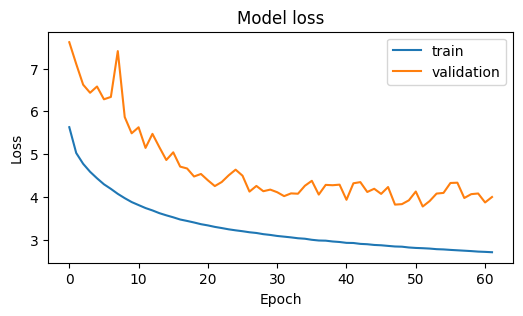

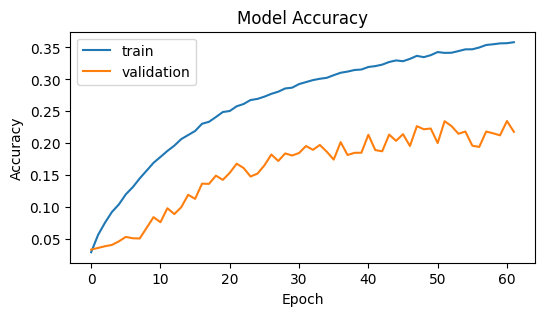

In [26]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(6,3)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(6,3)).set(xlabel='Epoch',ylabel='Accuracy')

* data augmentation
* normalize image
* reshape label vector (from horizontal, to vertical)
* create model
* fit
* test
* validate